# Import necessary library

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from plotnine import *
from matplotlib.ticker import PercentFormatter
import numpy as np
import difflib
from IPython.display import display # Import display function to render widgets and DataFrames in Jupyter Notebook
import ipywidgets as widgets # Import the ipywidgets library for interactive widgets (dropdowns, sliders, etc.)
import ipywidgets as widgets
import matplotlib.pyplot as plt

# JDW.L analysis

In [2]:
target_ticker = yf.Ticker("JDW.L")
print(target_ticker.info)

{'address1': 'Wetherspoon House', 'address2': 'Central Park Reeds Crescent', 'city': 'Watford', 'zip': 'WD24 4QL', 'country': 'United Kingdom', 'phone': '44 1923 477 777', 'website': 'https://www.jdwetherspoon.com', 'industry': 'Restaurants', 'industryKey': 'restaurants', 'industryDisp': 'Restaurants', 'sector': 'Consumer Cyclical', 'sectorKey': 'consumer-cyclical', 'sectorDisp': 'Consumer Cyclical', 'longBusinessSummary': 'J D Wetherspoon plc owns and operates pubs and hotels in the United Kingdom and the Republic of Ireland. The company was founded in 1979 and is based in Watford, the United Kingdom.', 'fullTimeEmployees': 42009, 'companyOfficers': [{'maxAge': 1, 'name': 'Mr. Timothy Randall Martin', 'age': 69, 'title': 'Executive Chairman', 'yearBorn': 1955, 'fiscalYear': 2024, 'totalPay': 339000, 'exercisedValue': 0, 'unexercisedValue': 0}, {'maxAge': 1, 'name': 'Mr. John  Hutson', 'age': 59, 'title': 'CEO, Member of Management Board & Executive Director', 'yearBorn': 1965, 'fiscal

In [3]:
target_ticker.ticker

'JDW.L'

## Financial Statement Data Cleaning and Preparation

In [4]:
# ------------------------------
# Get financial statement data
# ------------------------------
def get_financial_statement_data(target_ticker: str, statement_type: str) -> pd.DataFrame:
    """
    Download a specific financial statement for a given ticker.

    Parameters
    ----------
    target_ticker : str
        The stock ticker symbol (e.g., 'JDW.L')
    statement_type : str
        One of {'income', 'balance', 'cashflow'} or common aliases
        - 'income' / 'income_statement' / 'p&l' / 'pnl' / 'pl'
        - 'balance' / 'balance_sheet' / 'bs'
        - 'cashflow' / 'cashflow_statement' / 'cash_flow' / 'cf'

    Returns
    -------
    pd.DataFrame
        The requested financial statement DataFrame (years as columns).

    Raises
    ------
    ValueError
        If statement_type is invalid or if no data is returned.
    """

    # Normalize to a canonical key (ALL KEYS LOWERCASE so .lower() lookup works)
    # Map user input to the correct statement key
    stype_map = {
        "p&l": "income_statement",
        "pnl": "income_statement",
        "pl": "income_statement",
        "income": "income_statement",
        "income_statement": "income_statement",

        "balance": "balance_sheet",
        "balance_sheet": "balance_sheet",
        "bs": "balance_sheet",

        "cashflow": "cashflow_statement",
        "cash_flow": "cashflow_statement",
        "cashflow_statement": "cashflow_statement",
        "cf": "cashflow_statement"
    }

    # Normalize input safely (handles None or unexpected casing/spacing)
    key = stype_map.get((statement_type or "").strip().lower())
    if key is None:
        raise ValueError(
            "statement_type must be one of: "
            "'income_statement', 'balance'/'balance_sheet', "
            "'cashflow'/'cashflow_statement'"
        )

    # Normalize and initialize ticker
    target = yf.Ticker(target_ticker.strip().upper())

    # Fetch the requested statement
    if key == "income_statement":
        statement = target.get_income_stmt(as_dict=False, pretty=True, freq="yearly")
    elif key == "balance_sheet":
        statement = target.get_balance_sheet(as_dict=False, pretty=True, freq="yearly")
    else:  # cashflow
        statement = target.get_cash_flow(as_dict=False, pretty=True, freq="yearly")

    # Check if statement is valid
    if statement is None or not isinstance(statement, pd.DataFrame) or statement.empty:
        raise ValueError(f"No {key.replace('_', ' ')} data returned for {target_ticker}.")

    # Ensure columns are string (avoid Timestamp index issues)
    statement.columns = statement.columns.astype(str)

    # Return the cleaned financial statement DataFrame
    return statement.copy()

Scope of statement
*   statement is a local variable inside the function. It only exists while the function is running.
*   It’s not a global variable (A global variable is defined outside of functions and accessible everywhere).

In [5]:
#import difflib
#import pandas as pd
#from IPython.display import display  # ✅ ensure display() works in notebooks

# ------------------------------
# Query with substring + fuzzy matching + used tracker
# ------------------------------
def query_financial_statement(statement: pd.DataFrame, row_name=None, year=None):
    """
    Query a financial statement DataFrame with substring + fuzzy matching.
    Tracks used matches so repeated queries exclude already chosen matches.
    Resets per function call (no carryover between tickers/statements).
    """

    # Guard: ensure valid DataFrame
    if statement is None or not isinstance(statement, pd.DataFrame) or statement.empty:
        raise ValueError("Provided statement is invalid or empty.")

    used_matches = set()  # Tracks already chosen matches; resets each function call

    # --- Matching helper ---
    def match_item(query, choices, name="item", is_year=False):
        """
        Find the best match for a given query (row or year).
        - Prefers substring search first
        - Falls back to fuzzy match if no substring hits
        - Excludes matches already used in this query
        """
        if query is None:  # If query not provided, skip
            return None

        # Convert all choices to strings and remove already used matches
        choices_str = [str(c) for c in choices if str(c) not in used_matches]
        q = str(query).lower()  # Lowercase for case-insensitive matching

        if not choices_str:  # Nothing left to search
            print(f"\n⚠️ No remaining matches available for {name}.")
            return None

        # Year handling: auto-match if prefix matches (e.g. "2023" → "2023-07-31")
        if is_year:
            exact_matches = [c for c in choices_str if c.startswith(str(query))]
            if exact_matches:
                chosen = exact_matches[0]
                used_matches.add(chosen)
                return chosen

        # Substring search (case-insensitive)
        substring_matches = [c for c in choices_str if q in c.lower()]
        if substring_matches:
            if len(substring_matches) == 1:  # Exactly one match → auto-pick
                chosen = substring_matches[0]
                used_matches.add(chosen)
                print(f"Auto-selected {name}: {chosen}")
                return chosen
            else:  # Multiple matches → let user pick
                print(f"\nMultiple matches found for '{query}' in {name} list (excluding used):")
                for i, m in enumerate(substring_matches, 1):
                    print(f"{i}. {m}")
                try:
                    choice = int(input("Enter the number of your choice: "))
                    if 1 <= choice <= len(substring_matches):
                        chosen = substring_matches[choice - 1]
                        used_matches.add(chosen)
                        return chosen
                except Exception:
                    pass
                # If invalid input, default to first match
                chosen = substring_matches[0]
                used_matches.add(chosen)
                print(f"⚠️ Invalid choice, using {chosen}")
                return chosen

        # Fallback: fuzzy search (best approximate matches)
        matches = difflib.get_close_matches(str(query), choices_str, n=len(choices_str), cutoff=0.4)
        if not matches:  # Nothing found
            print(f"\n⚠️ No matches found for {query} in {name} list.")
            return None
        elif len(matches) == 1:  # Exactly one fuzzy match
            chosen = matches[0]
            used_matches.add(chosen)
            print(f"Auto-selected {name}: {chosen}")
            return chosen
        else:  # Multiple fuzzy matches → ask user
            print(f"\nMultiple matches found for '{query}' in {name} list (excluding used):")
            for i, m in enumerate(matches, 1):
                print(f"{i}. {m}")
            try:
                choice = int(input("Enter the number of your choice: "))
                if 1 <= choice <= len(matches):
                    chosen = matches[choice - 1]
                    used_matches.add(chosen)
                    return chosen
            except Exception:
                pass
            # Default to first match if user input fails
            chosen = matches[0]
            used_matches.add(chosen)
            print(f"⚠️ Invalid choice, using {chosen}")
            return chosen

    # Normalize inputs to lists
    row_names = row_name if isinstance(row_name, list) else ([row_name] if row_name else [])
    years = year if isinstance(year, list) else ([year] if year else [])

    # Run matching for rows
    matched_rows = [match_item(r, list(statement.index), name="row") for r in row_names] if row_names else []
    # Run matching for years
    matched_years = [match_item(y, list(statement.columns), name="year", is_year=True) for y in years] if years else []

    # Drop None matches
    matched_rows = [r for r in matched_rows if r]
    matched_years = [y for y in matched_years if y]

    # Lookup logic based on matches
    if matched_rows and matched_years:  # Both rows and years provided
        if len(matched_rows) > 1 or len(matched_years) > 1:  # Multiple selections → DataFrame
            result = statement.loc[matched_rows, matched_years]
            print("\nResult (sub-DataFrame):")
            display(result)
            return result
        else:  # Single row + single year → scalar
            value = statement.loc[matched_rows[0], matched_years[0]]
            print(f"\nResult → {matched_rows[0]} in {matched_years[0]}: {value}")
            return value

    elif matched_rows:  # Only rows matched
        result = statement.loc[matched_rows, :]
        print("\nResult (rows):")
        display(result)
        return result

    elif matched_years:  # Only years matched
        result = statement.loc[:, matched_years]
        print("\nResult (years):")
        display(result)
        return result

    # If nothing matched → return the whole statement
    return statement.copy()

In [6]:
def flag_statement_issues(statement: pd.DataFrame, statement_name: str) -> pd.DataFrame:
    """
    Identify and flag 0 or NaN values in a financial statement DataFrame.

    Parameters
    ----------
    statement : pd.DataFrame
        The financial statement DataFrame.
    statement_name : str
        The name of the statement (e.g., "Income Statement") for printing.

    Returns
    -------
    pd.DataFrame
        A filtered DataFrame showing only rows and columns
        that contain at least one 0 or NaN, with flagged cells marked by '*'.
    """

    # Guard: ensure input is a valid DataFrame
    if statement is None or not isinstance(statement, pd.DataFrame) or statement.empty:
        raise ValueError(f"Invalid or empty statement provided for {statement_name}.")

    # Copy the statement so we don’t overwrite the raw version
    flagged_statement = statement.copy()

    # Build a mask: True where value is 0 or NaN
    flag_mask = flagged_statement.applymap(lambda x: x == 0 or pd.isna(x))

    # Iterate through every row of the DataFrame
    for index, row in flagged_statement.iterrows():
        for col, value in row.items():
            if flag_mask.loc[index, col]:
                # Replace NaN with clearer label before appending '*'
                if pd.isna(value):
                    flagged_statement.loc[index, col] = "NaN*"
                else:
                    flagged_statement.loc[index, col] = f"{value}*"

    # Identify rows and columns with at least one flagged cell
    rows_with_flags = flag_mask.any(axis=1)
    cols_with_flags = flag_mask.any(axis=0)

    # Extract only the subset of the DataFrame with issues
    issues_statement = flagged_statement.loc[rows_with_flags, cols_with_flags]

    # Print a descriptive header
    print(f"\n{statement_name} Issues:")
    return issues_statement.copy()

Flagging missing or zero values in the statement for JDW.L using lamda → lambda creates an anonymous function (a function without a name). It checks two conditions:
*   x == 0 → Is the cell exactly zero?
*   pd.isna(x) → Is the cell missing (NaN)?
It returns True if either condition is satisfied, otherwise False.

## Balance Sheet (Target)

In [7]:
# Get the balance_sheet
balance_sheet_target = get_financial_statement_data(target_ticker.ticker, "balance_sheet")

# Print column headings (years) as a list
print("\nAvailable Years (columns):")
print(balance_sheet_target.columns.tolist())

# Print row headings (line items)
print("\nAvailable Line Items (rows):")
for row in balance_sheet_target.index:
    print(f" - {row}")


Available Years (columns):
['2024-07-31', '2023-07-31', '2022-07-31', '2021-07-31']

Available Line Items (rows):
 - Treasury Shares Number
 - Ordinary Shares Number
 - Share Issued
 - Net Debt
 - Total Debt
 - Tangible Book Value
 - Invested Capital
 - Working Capital
 - Net Tangible Assets
 - Capital Lease Obligations
 - Common Stock Equity
 - Total Capitalization
 - Total Equity Gross Minority Interest
 - Stockholders Equity
 - Retained Earnings
 - Additional Paid In Capital
 - Capital Stock
 - Common Stock
 - Total Liabilities Net Minority Interest
 - Total Non Current Liabilities Net Minority Interest
 - Derivative Product Liabilities
 - Non Current Deferred Taxes Liabilities
 - Long Term Debt And Capital Lease Obligation
 - Long Term Capital Lease Obligation
 - Long Term Debt
 - Current Liabilities
 - Current Debt And Capital Lease Obligation
 - Current Capital Lease Obligation
 - Current Provisions
 - Payables
 - Other Payable
 - Total Tax Payable
 - Accounts Payable
 - Total A

In [8]:
balance_sheet_target.loc["Treasury Shares Number"]
balance_sheet_target.loc["Ordinary Shares Number"]
balance_sheet_target.loc["Share Issued"]

inspecting = pd.DataFrame({
    "Treasury Shares Number": balance_sheet_target.loc["Treasury Shares Number"],
    "Ordinary Shares Number": balance_sheet_target.loc["Ordinary Shares Number"],
    "Share Issued": balance_sheet_target.loc["Share Issued"]
})

display(inspecting)

,Treasury Shares Number,Ordinary Shares Number,Share Issued
2024-07-31,NaN,NaN,NaN
2023-07-31,0.0,128750155.0,128750155.0
2022-07-31,NaN,128750155.0,128750155.0
2021-07-31,NaN,128750155.0,128750155.0


## Cash Flow statement (Target)

In [9]:
# Get the balance_sheet
cash_flow_target = get_financial_statement_data("JDW.L", "CF")

# Print column headings (years) as a list
print("\nAvailable Years (columns):")
print(cash_flow_target.columns.tolist())

# Print row headings (line items)
print("\nAvailable Line Items (rows):")
for row in cash_flow_target.index:
    print(f" - {row}")


Available Years (columns):
['2024-07-31', '2023-07-31', '2022-07-31', '2021-07-31']

Available Line Items (rows):
 - Free Cash Flow
 - Repurchase Of Capital Stock
 - Repayment Of Debt
 - Issuance Of Debt
 - Issuance Of Capital Stock
 - Capital Expenditure
 - End Cash Position
 - Beginning Cash Position
 - Changes In Cash
 - Financing Cash Flow
 - Net Common Stock Issuance
 - Common Stock Payments
 - Common Stock Issuance
 - Net Issuance Payments Of Debt
 - Net Long Term Debt Issuance
 - Long Term Debt Payments
 - Long Term Debt Issuance
 - Investing Cash Flow
 - Net Other Investing Changes
 - Net Business Purchase And Sale
 - Purchase Of Business
 - Net PPE Purchase And Sale
 - Sale Of PPE
 - Purchase Of PPE
 - Operating Cash Flow
 - Taxes Refund Paid
 - Interest Received Cfo
 - Interest Paid Cfo
 - Change In Working Capital
 - Change In Payable
 - Change In Inventory
 - Change In Receivables
 - Other Non Cash Items
 - Stock Based Compensation
 - Deferred Tax
 - Depreciation And Amort

In [10]:
# Access Operating Cash Flow row correctly
if 'Operating Cash Flow' in cash_flow_target.index:
    operating_cash_flow = cash_flow_target.loc['Operating Cash Flow']
    print("\nOperating Cash Flow values:")  # Start on new line
    print(operating_cash_flow)  # Print the values on separate lines
else:
    print("\n'Operating Cash Flow' not found in the cash flow statement")
    print("Available metrics:", cash_flow_target.index.tolist())


Operating Cash Flow values:
2024-07-31    172562000.0
2023-07-31    362411000.0
2022-07-31    119347000.0
2021-07-31    -35302000.0
Name: Operating Cash Flow, dtype: float64


## Income statement (Target)

In [11]:
# Get the income statement
income_statement_target = get_financial_statement_data("JDW.L", "P&L")

# Print column headings (years) as a list
print("\nAvailable Years (columns):")
print(income_statement_target.columns.tolist())

# Print row headings (line items)
print("\nAvailable Line Items (rows):")
for row in income_statement_target.index:
    print(f" - {row}")


Available Years (columns):
['2024-07-31', '2023-07-31', '2022-07-31', '2021-07-31']

Available Line Items (rows):
 - Tax Effect Of Unusual Items
 - Tax Rate For Calcs
 - Normalized EBITDA
 - Total Unusual Items
 - Total Unusual Items Excluding Goodwill
 - Net Income From Continuing Operation Net Minority Interest
 - Reconciled Depreciation
 - Reconciled Cost Of Revenue
 - EBITDA
 - EBIT
 - Net Interest Income
 - Interest Expense
 - Interest Income
 - Normalized Income
 - Net Income From Continuing And Discontinued Operation
 - Total Expenses
 - Rent Expense Supplemental
 - Total Operating Income As Reported
 - Diluted Average Shares
 - Basic Average Shares
 - Diluted EPS
 - Basic EPS
 - Diluted NI Availto Com Stockholders
 - Net Income Common Stockholders
 - Otherunder Preferred Stock Dividend
 - Net Income
 - Net Income Including Noncontrolling Interests
 - Net Income Continuous Operations
 - Tax Provision
 - Pretax Income
 - Special Income Charges
 - Other Special Charges
 - Impairm

## Combination Query & Issues Inspection (Target)

In [12]:
from IPython.display import display, HTML, clear_output

# ------------------------------
# Widget Function: Statement + Issues
# ------------------------------
def financials_target_widget(target_ticker="JDW.L"):   # ✅ renamed to target_ticker for consistency

    # Dropdown for statement selection
    target_statement_dropdown = widgets.Dropdown(
        options=[
            ("Income Statement", "P&L"),         # User sees "Income Statement", function gets "P&L"
            ("Balance Sheet", "balance_sheet"),
            ("Cash Flow Statement", "CF"),
        ],
        description="Statement:",
        style={'description_width': 'initial'}
    )

    # Toggle for view type
    view_toggle = widgets.ToggleButtons(
        options=["Full Statement", "Inspect Issues"],
        description="View:",
        style={'description_width': 'initial'},
        button_style="info"
    )

    # Output area
    target_output = widgets.Output()

    # Function to update display
    def update_display(*args):
        with target_output:
            clear_output()
            key = target_statement_dropdown.value
            label = target_statement_dropdown.label
            try:
                # ✅ use target_ticker instead of ticker
                statement = get_financial_statement_data(target_ticker, key)

                display(HTML(
                    f'<div style="background:black;color:white;padding:10px;border-radius:8px;">'
                    f'<h3 style="margin:5px 0;">{label} - {target_ticker}</h3>'
                    f'<p style="margin:0;font-size:13px;">View: {view_toggle.value}</p>'
                    f'</div>'
                ))

                if view_toggle.value == "Full Statement":
                    display(statement)
                else:
                    issues = flag_statement_issues(statement, label)
                    display(issues)
            except Exception as e:
                print("Error:", str(e))

    # Attach callbacks
    target_statement_dropdown.observe(update_display, names='value')
    view_toggle.observe(update_display, names='value')

    # Display UI
    display(widgets.VBox([target_statement_dropdown, view_toggle, target_output]))

    # Initial render
    update_display()

# ------------------------------
# Run the merged widget
# ------------------------------
financials_target_widget(target_ticker.ticker)   # Call the function for JDW.L ticker → displays interactive widget

## Ratios

Sourced from Balance Sheet

In [13]:
# Query multiple fuzzy row matches to view required components before calculating ratios (from Cash Flow statement)
#bs_result = query_financial_statement(balance_sheet_target,
#    row_name=["asset", "debt", "cash"],
#    year=["2021", "2022", "2023", "2024"])

In [14]:
# Flag potential data issues in the income statement and display the flagged results
#bs_target_issues = flag_statement_issues(balance_sheet_target, "balance sheet")
#display(bs_target_issues )

Sourced from Cash Flow statement

In [15]:
# Query multiple fuzzy row matches to view required components before calculating ratios (from Cash Flow statement)
#cf_result = query_financial_statement(cash_flow_target,
    #row_name=["operating", "cash flow", "cash flow", "capital", "capital"],  # query items for inspection
    #year=["2021", "2022", "2023", "2024"])

In [16]:
# Flag potential data issues in the cash flow statement and display the flagged results
# cf_target_issues = flag_statement_issues(cash_flow_target, "cashflow")
# display(cf_target_issues)

Sourced from Income statement

In [17]:
# Query multiple fuzzy row matches to view required components before calculating ratios (from Income statement)
#pl_result = query_financial_statement(income_statement_target,
#    row_name=["cost", "cost", "revenue", "revenue", "admin", "admin", "expense", "expense", "expense", "tax", "tax", "income"],  # query items for inspection
#    year=["2021", "2022", "2023", "2024"])

In [18]:
# From the query result: Reconciled Cost Of Revenue	= Cost of Revenue and Total Revenue = Operating Revenue
#display(pl_result)

In [19]:
# Flag potential data issues in the income statement and display the flagged results
income_target_issues = flag_statement_issues(income_statement_target, "income_statement")
display(income_target_issues)


income_statement Issues:


/tmp/ipython-input-3251802956.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/tmp/ipython-input-3251802956.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NaN*' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/tmp/ipython-input-3251802956.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NaN*' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/tmp/ipython-input-3251802956.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0*' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/tmp/ipython-input-3251802956.py:37: FutureWarning: Setting an item of incompatible dtype is depre

,2024-07-31,2023-07-31,2022-07-31,2021-07-31
Reconciled Cost Of Revenue,NaN*,NaN*,1640202000.0,844574000.0
Otherunder Preferred Stock Dividend,0.0*,0.0*,0.0*,0.0*
Other Operating Expenses,1896009000.0,1817982000.0,1714757000.0,NaN*
Depreciation And Amortization In Income Statement,-4139000.0,NaN*,NaN*,NaN*
Depreciation Income Statement,-4139000.0,NaN*,NaN*,NaN*
Selling General And Administration,NaN*,NaN*,45171000.0,37280000.0
General And Administrative Expense,NaN*,NaN*,45171000.0,37280000.0
Gross Profit,NaN*,NaN*,100275000.0,-72019000.0
Cost Of Revenue,NaN*,NaN*,1640202000.0,844574000.0


Standard IFRS/UK GAAP:
*   Revenue - Cost of sales = Gross profit
*   Gross profit - Administration costs = Operating profit
*   Operating profit - Finance costs (Interest expense) - Tax provision = Net income

In yfinance:
*   Gross Profit = Operating Income + Operating Expense (excl. admin) but yfinance lumps a lot under "Operating Expense".
*   Operating Income = Revenue - Total Operating Expense → Total Operating Expense=Revenue - Operating Income
*   Gross Profit (approx) = Operating Income + Admin Costs (if available)

Not possible to compute

In [20]:
# Extract relevant rows from your income statement DataFrame
total_revenue = income_statement_target.loc["Total Revenue"]
cost_of_revenue = income_statement_target.loc["Cost Of Revenue"]
gross_profit_calc = income_statement_target.loc["Total Revenue"] - income_statement_target.loc["Cost Of Revenue"]
gross_profit_reported = income_statement_target.loc["Gross Profit"]
sga_expense = income_statement_target.loc["General And Administrative Expense"]
operating_income = income_statement_target.loc["Operating Income"]
operating_expense = income_statement_target.loc["Operating Expense"]
pretax_income = income_statement_target.loc["Pretax Income"]
tax_provision = income_statement_target.loc["Tax Provision"]
net_income_calc = income_statement_target.loc["Pretax Income"] - income_statement_target.loc["Tax Provision"]
net_income_reported = income_statement_target.loc["Net Income"]

# Assemble comparison table
gross_profit_inspect = pd.DataFrame({
    "Revenue": total_revenue,
    "Cost of Revenue": cost_of_revenue,
    "Gross Profit (calc)": gross_profit_calc,
    "Gross Profit (computed)": gross_profit_reported,
    "Operating Income": operating_income,
    "SG&A": sga_expense,
    "Total Operating Expense (yfinance)": operating_expense,
    "Pretax Income": pretax_income,
    "Tax Provision": tax_provision,
    "Net Income (calc)": net_income_calc,
    "Net Income (reported)": net_income_reported,
})

display(gross_profit_inspect)

,Revenue,Cost of Revenue,Gross Profit (calc),Gross Profit (computed),Operating Income,SG&A,Total Operating Expense (yfinance),Pretax Income,Tax Provision,Net Income (calc),Net Income (reported)
2024-07-31,2.035500e+09,NaN,NaN,NaN,143644000.0,NaN,1.891856e+09,60620000.0,11835000.0,48785000.0,48785000.0
2023-07-31,1.925044e+09,NaN,NaN,NaN,107116000.0,NaN,1.817928e+09,90511000.0,30924000.0,59587000.0,59587000.0
2022-07-31,1.740477e+09,1.640202e+09,100275000.0,100275000.0,55104000.0,45171000.0,1.685373e+09,26269000.0,7002000.0,19267000.0,19267000.0
2021-07-31,7.725550e+08,8.445740e+08,-72019000.0,-72019000.0,-109299000.0,37280000.0,3.728000e+07,-194636000.0,-17630000.0,-177006000.0,-177006000.0


### Profitability ratios (Margin ratios)
Measure a company's ability to generate profits from its sales and operations.

Gross Profit Margin

In [21]:
# Copy DataFrame for Gross Profit Margin analysis to avoid modifying the original DataFrame.
gp_margin_target = gross_profit_inspect.copy()

# Compute Gross Profit Margin per year
# Formula: Gross Profit Margin = Gross Profit ÷ Revenue
# This creates a new column "Gross Profit Margin" in the DataFrame.
gp_margin_target["Gross Profit Margin"] = gp_margin_target["Gross Profit (computed)"] / gp_margin_target["Revenue"]

# Filter only valid positive margins
# Here we temporarily filter the DataFrame to keep only rows where:
# - Gross Profit Margin is not NaN
# - Gross Profit Margin > 0 (exclude negative and zero margins)
gp_margin_target = gp_margin_target.loc[
    gp_margin_target["Gross Profit Margin"].notna() & (gp_margin_target["Gross Profit Margin"] > 0)]

# Compute mean of positive margins only
# From the filtered rows, compute the mean of positive Gross Profit Margins.
# This mean will later be used to impute missing values.
mean_gp_margin_target = gp_margin_target["Gross Profit Margin"].mean()

# Re-copy original for imputation (so we don’t lose missing years)
# We reset gp_margin_target back to the original full DataFrame (with missing years)
# because the filtered DataFrame above only had positive values.
gp_margin_target = gross_profit_inspect.copy()

# Impute missing Gross Profit using mean margin
# For each year in the DataFrame:
# - Check if Gross Profit is NaN or zero
# - If yes, estimate Gross Profit by multiplying that year’s Revenue by mean margin
for year in gp_margin_target.index:
    gp_value = gp_margin_target.at[year, "Gross Profit (computed)"]  # Use .at for safe scalar access
    if pd.isna(gp_value) or gp_value == 0:
        gp_margin_target.at[year, "Gross Profit (computed)"] = gp_margin_target.at[year, "Revenue"] * mean_gp_margin_target

# Recalculate Gross Profit Margin for all years (including imputed ones)
# After filling missing values, we recalculate Gross Profit Margin for consistency.
gp_margin_target["Gross Profit Margin"] = gp_margin_target["Gross Profit (computed)"] / gp_margin_target["Revenue"]
# Add a column for percentage
gp_margin_target["Gross Profit Margin (%)"] = (gp_margin_target["Gross Profit Margin"] * 100).round(2) # Round to 2 decimal places

# Display results
# Show a simplified table with just Revenue, Gross Profit (reported/imputed), and Gross Profit Margin.
print("\nGross Profit Margin (%)")
display(gp_margin_target[["Revenue", "Gross Profit (computed)", "Gross Profit Margin", "Gross Profit Margin (%)"]])

# Print mean margin used
# This prints the mean Gross Profit Margin (based only on positive values) as a percentage.
print(f"Mean Gross Profit Margin (positive values only) used for imputation: {mean_gp_margin_target:.2%}")


Gross Profit Margin (%)


,Revenue,Gross Profit (computed),Gross Profit Margin,Gross Profit Margin (%)
2024-07-31,2.035500e+09,1.172723e+08,0.057614,5.76
2023-07-31,1.925044e+09,1.109086e+08,0.057614,5.76
2022-07-31,1.740477e+09,1.002750e+08,0.057614,5.76
2021-07-31,7.725550e+08,-7.201900e+07,-0.093222,-9.32


Mean Gross Profit Margin (positive values only) used for imputation: 5.76%


EBITDA Margin

In [22]:
# Compute EBITDA margin
ebitda_margin_target = income_statement_target.loc["EBITDA"] / income_statement_target.loc["Total Revenue"]

# Create a result DataFrame for clarity
ebitda_margin_target = pd.DataFrame({
    "Revenue": income_statement_target.loc["Total Revenue"],
    "EBITDA": income_statement_target.loc["EBITDA"],
    "EBITDA Margin": ebitda_margin_target,
    "EBITDA Margin (%)": (ebitda_margin_target * 100).round(2) # Add a column for percentage and round to 2 decimal places
})

# Display the result
print("\nEBITDA Margin (%)")
display(ebitda_margin_target)
print(f"EBITDA Margin (positive values only) used for imputation: {mean_gp_margin_target:.2%}")


EBITDA Margin (%)


,Revenue,EBITDA,EBITDA Margin,EBITDA Margin (%)
2024-07-31,2.035500e+09,230222000.0,0.113103,11.31
2023-07-31,1.925044e+09,267091000.0,0.138745,13.87
2022-07-31,1.740477e+09,199972000.0,0.114895,11.49
2021-07-31,7.725550e+08,-8182000.0,-0.010591,-1.06


EBITDA Margin (positive values only) used for imputation: 5.76%


Operating Profit Margin

In [23]:
# Calculate Operating Profit Margin
operating_profit_margin_target =  income_statement_target.loc["Operating Income"] / income_statement_target.loc["Total Revenue"]

# Create a result DataFrame for clarity and display
operating_profit_margin_target = pd.DataFrame({
    "Revenue": income_statement_target.loc["Total Revenue"],
    "Operating Income": income_statement_target.loc["Operating Income"],
    "Operating Profit Margin": operating_profit_margin_target,
    "Operating Profit Margin (%)": (operating_profit_margin_target*100).round(2) # Add a column for percentage and round to 2 decimal places
})

# Display the result
print("\nOperating Profit Margin (%)")
display(operating_profit_margin_target)


Operating Profit Margin (%)


,Revenue,Operating Income,Operating Profit Margin,Operating Profit Margin (%)
2024-07-31,2.035500e+09,143644000.0,0.070569,7.06
2023-07-31,1.925044e+09,107116000.0,0.055643,5.56
2022-07-31,1.740477e+09,55104000.0,0.031660,3.17
2021-07-31,7.725550e+08,-109299000.0,-0.141477,-14.15


Net Profit Margin

In [24]:
# Calculate Net Profit Margin
net_profit_margin_target = income_statement_target.loc["Net Income"] / income_statement_target.loc["Total Revenue"]

# Create a result DataFrame for clarity and display
net_profit_margin_target = pd.DataFrame({
    "Revenue": income_statement_target.loc["Total Revenue"],
    "Net Income": income_statement_target.loc["Net Income"],
    "Net Profit Margin": net_profit_margin_target,
    "Net Profit Margin (%)": (net_profit_margin_target * 100).round(2)  # as percentage, rounded to 2 decimals
})

# Display the result
print("\nNet Profit Margin (%)")
display(net_profit_margin_target)


Net Profit Margin (%)


,Revenue,Net Income,Net Profit Margin,Net Profit Margin (%)
2024-07-31,2.035500e+09,48785000.0,0.023967,2.40
2023-07-31,1.925044e+09,59587000.0,0.030954,3.10
2022-07-31,1.740477e+09,19267000.0,0.011070,1.11
2021-07-31,7.725550e+08,-177006000.0,-0.229118,-22.91


Cash Flow Margin

In [25]:
# Calculate Cash Flow Margin
cash_flow_margin_target = cash_flow_target.loc["Operating Cash Flow"] / income_statement_target.loc["Total Revenue"]

# Create a result DataFrame for clarity and display
cash_flow_margin_target = pd.DataFrame({
    "Revenue": income_statement_target.loc["Total Revenue"],
    "Operating Cash Flow": cash_flow_target.loc["Operating Cash Flow"],
    "Cash Flow Margin": cash_flow_margin_target,
    "Cash Flow Margin (%)": (cash_flow_margin_target * 100).round(2)  # as percentage, rounded to 2 decimals
})

# Display the result
print("\nCash Flow Margin (%)")
display(cash_flow_margin_target)


Cash Flow Margin (%)


,Revenue,Operating Cash Flow,Cash Flow Margin,Cash Flow Margin (%)
2024-07-31,2.035500e+09,172562000.0,0.084776,8.48
2023-07-31,1.925044e+09,362411000.0,0.188261,18.83
2022-07-31,1.740477e+09,119347000.0,0.068571,6.86
2021-07-31,7.725550e+08,-35302000.0,-0.045695,-4.57


Free Cash Flow Margin

In [26]:
fcf_manual = cash_flow_target.loc["Operating Cash Flow"] + cash_flow_target.loc["Capital Expenditure"] # Calculate Free Cash Flow manually by adding Operating Cash Flow and Capital Expenditure
fcf_reported = cash_flow_target.loc["Free Cash Flow"] # Get the reported Free Cash Flow from the cash flow statement

# Create a result DataFrame for clarity and display
fcf_compared = pd.DataFrame({ # Create a new pandas DataFrame to compare manual and reported FCF
    "Operating Cash Flow": cash_flow_target.loc["Operating Cash Flow"], # Include the Operating Cash Flow column
    "Capital Expenditure": cash_flow_target.loc["Capital Expenditure"], # Include the Capital Expenditure column
    "FCF (Manual computation)": fcf_manual, # Include the manually calculated Free Cash Flow
    "FCF (Reported)": fcf_reported # Include the reported Free Cash Flow
})

# Display the DataFrame comparing manual and reported Free Cash Flow
display(fcf_compared)

,Operating Cash Flow,Capital Expenditure,FCF (Manual computation),FCF (Reported)
2024-07-31,172562000.0,-110266000.0,62296000.0,62296000.0
2023-07-31,362411000.0,-73209000.0,289202000.0,289202000.0
2022-07-31,119347000.0,-119633000.0,-286000.0,-286000.0
2021-07-31,-35302000.0,-57681000.0,-92983000.0,-92983000.0


In [27]:
# Calculate Free Cash Flow Margin
fcf_margin = fcf_reported / income_statement_target.loc["Total Revenue"]

# Create a result DataFrame for clarity and display for FCF Margin
fcf_margin_target = pd.DataFrame({
    "Revenue": income_statement_target.loc["Total Revenue"],
    "Free Cash Flow": fcf_reported,
    "Free Cash Flow Margin": fcf_margin,
    "Free Cash Flow Margin (%)": (fcf_margin*100).round(2)
})

print("\nFree Cash Flow Margin (%)") # Print a header for the Free Cash Flow Margin table
display(fcf_margin_target) # Display the Free Cash Flow Margin DataFrame


Free Cash Flow Margin (%)


,Revenue,Free Cash Flow,Free Cash Flow Margin,Free Cash Flow Margin (%)
2024-07-31,2.035500e+09,62296000.0,0.030605,3.06
2023-07-31,1.925044e+09,289202000.0,0.150231,15.02
2022-07-31,1.740477e+09,-286000.0,-0.000164,-0.02
2021-07-31,7.725550e+08,-92983000.0,-0.120358,-12.04


### Profitability ratios (Return ratios)
Measure a company's ability to generate profits from its sales and operations.

Return on Assets (ROA)

In [28]:
# Extract Total Assets and Net Income
total_assets = balance_sheet_target.loc["Total Assets"]
net_income = income_statement_target.loc["Net Income"]

# Calculate average assets per year (shifted)
avg_assets = (total_assets.shift(1) + total_assets) / 2

# For the latest year, fallback to end-of-period assets if average is NaN
avg_assets.iloc[0] = total_assets.iloc[0]  # first year only has end-period assets
avg_assets.iloc[-1] = total_assets.iloc[-1] if pd.isna(avg_assets.iloc[-1]) else avg_assets.iloc[-1]

# Compute ROA
roa_target = net_income / avg_assets

# Put in DataFrame for display
roa_target = pd.DataFrame({
    "Net Income": net_income,
    "Total Assets": total_assets,
    "Average Assets (adjusted)": avg_assets,
    "ROA (%)": (roa_target * 100).round(2)
})

print("\nReturn on Assets (ROA):")
display(roa_target)


Return on Assets (ROA):


,Net Income,Total Assets,Average Assets (adjusted),ROA (%)
2024-07-31,48785000.0,1.904370e+09,1.904370e+09,2.56
2023-07-31,59587000.0,1.979904e+09,1.942137e+09,3.07
2022-07-31,19267000.0,2.049371e+09,2.014638e+09,0.96
2021-07-31,-177006000.0,2.009658e+09,2.029514e+09,-8.72


Return on Equity (ROE)

In [29]:
# Equity ≈ Total Assets − Net Debt − Other Liabilities method where Other Liabilities ≈ Total Liabilities − Net Debt
total_liabilities = balance_sheet_target.loc["Total Liabilities Net Minority Interest"]
net_debt = balance_sheet_target.loc["Net Debt"]
other_liabilities = total_liabilities - net_debt
# Get the reported Equity from Balance Sheet
equity_reported = balance_sheet_target.loc["Stockholders Equity"]

equity_manual = total_assets - net_debt - other_liabilities

# Create a result DataFrame for clarity and display
equity_compared = pd.DataFrame({
    "Total Assets": total_assets,
    "Net Debt": net_debt,
    "Other Liabilities": other_liabilities,
    "Equity (Manual computation)": equity_manual,
    "Equity (Reported)": equity_reported
})

# Display the DataFrame comparing manual and reported Free Cash Flow
display(equity_compared)

,Total Assets,Net Debt,Other Liabilities,Equity (Manual computation),Equity (Reported)
2024-07-31,1.904370e+09,661901000.0,840842000.0,401627000.0,401627000.0
2023-07-31,1.979904e+09,640470000.0,926376000.0,413058000.0,413058000.0
2022-07-31,2.049371e+09,886083000.0,841403000.0,321885000.0,321885000.0
2021-07-31,2.009658e+09,829231000.0,902450000.0,277977000.0,277977000.0


In [30]:
# Average equity calculation
avg_equity = (equity_reported.shift(1) + equity_reported) / 2

# For the latest year, fallback to end-of-period assets if average is NaN
avg_equity.iloc[0] = equity_reported.iloc[0]
avg_equity.iloc[-1] = equity_reported.iloc[-1] if pd.isna(avg_equity.iloc[-1]) else avg_equity.iloc[-1]

# Compute ROE
roe_target = net_income / avg_equity

# Put in DataFrame for display
roe_target = pd.DataFrame({
    "Net Income": net_income,
    "Total Equity": equity_reported,
    "Average Equity (adjusted)": avg_equity,
    "ROE (%)": (roe_target * 100).round(2)
})

# Display
print("\nReturn on Equity (ROE):")
display(roe_target)


Return on Equity (ROE):


,Net Income,Total Equity,Average Equity (adjusted),ROE (%)
2024-07-31,48785000.0,401627000.0,401627000.0,12.15
2023-07-31,59587000.0,413058000.0,407342500.0,14.63
2022-07-31,19267000.0,321885000.0,367471500.0,5.24
2021-07-31,-177006000.0,277977000.0,299931000.0,-59.02


Return on Invested Capital (ROIC)

In [31]:
# EBIT, Net Income & Tax Provision from income statement
ebit = income_statement_target.loc["EBIT"]
net_income = income_statement_target.loc["Net Income"]
tax_provision = income_statement_target.loc["Tax Provision"]

# Tax Rate (if available) = Tax / Pretax Income
pretax_income = income_statement_target.loc["Pretax Income"]
tax_rate = (tax_provision / pretax_income).clip(lower=0, upper=1)  # clamp between 0–100%

# Invested Capital = Net Debt + Equity
invested_capital = net_debt + equity_reported

In [32]:
# NOPAT and Invested Capital calculation
avg_invested_capital = (invested_capital.shift(1) + invested_capital) / 2

avg_invested_capital.iloc[0] = invested_capital.iloc[0]
avg_invested_capital.iloc[-1] = invested_capital.iloc[-1] if pd.isna(avg_invested_capital.iloc[-1]) else avg_invested_capital.iloc[-1]

nopat = ebit * (1 - tax_rate.fillna(0.25))  # assume 25% if missing

# Compute ROIC
roic_target = nopat / avg_invested_capital

# Put in DataFrame for display
roic_target = pd.DataFrame({
    "EBIT": ebit,
    "Pretax Income": pretax_income,
    "Tax Provision": tax_provision,
    "Tax Rate": tax_rate,
    "NOPAT": nopat,
    "Average Invested Capital (adjusted)": avg_invested_capital,
    "ROIC (%)": (roic_target*100).round(2)
})

# Display
print("\nReturn on Invested Capital (ROIC):")
display(roic_target)


Return on Invested Capital (ROIC):


,EBIT,Pretax Income,Tax Provision,Tax Rate,NOPAT,Average Invested Capital (adjusted),ROIC (%)
2024-07-31,127840000.0,60620000.0,11835000.0,0.195233,1.028815e+08,1.063528e+09,9.67
2023-07-31,157350000.0,90511000.0,30924000.0,0.341660,1.035898e+08,1.058528e+09,9.79
2022-07-31,83127000.0,26269000.0,7002000.0,0.266550,6.096950e+07,1.130748e+09,5.39
2021-07-31,-129102000.0,-194636000.0,-17630000.0,0.090579,-1.174080e+08,1.157588e+09,-10.14


### Liquidity ratios
Measure a company's ability to meet its short-term obligations and pay its bills

Current ratio

In [33]:
# From the Balance Sheet
current_assets = balance_sheet_target.loc["Current Assets"]
current_liabilities = balance_sheet_target.loc["Current Liabilities"]

# Calculate Current Ratio: Current Assets / Current Liabilities
current_ratio = current_assets / current_liabilities

# Create a result DataFrame for clarity and display
current_ratio_target = pd.DataFrame({
    "Current Assets": current_assets,
    "Current Liabilities": current_liabilities,
    "Current Ratio": current_ratio.round(2)
})

print("\nCurrent Ratio (%):") # Print a header for the output
display(current_ratio_target) # Display the Current Ratio results DataFrame


Current Ratio (%):


,Current Assets,Current Liabilities,Current Ratio
2024-07-31,122138000.0,351389000.0,0.35
2023-07-31,159110000.0,387257000.0,0.41
2022-07-31,100950000.0,338750000.0,0.30
2021-07-31,91513000.0,335624000.0,0.27


Acid-Test Ratio

In [34]:
# From the Balance Sheet
inventory = balance_sheet_target.loc["Inventory"]

# Calculate Acid-Test Ratio: (Current Assets - Inventory) / Current Liabilities
acid_test_ratio = (current_assets - inventory) / current_liabilities

# Create a result DataFrame for clarity and display
acid_test_ratio_target = pd.DataFrame({
    "Current Assets": current_assets, # Display Current Assets
    "Inventory": inventory, # Display Inventory
    "Current Liabilities": current_liabilities, # Display Current Liabilities
    "Acid-Test Ratio": acid_test_ratio.round(2) # Display Acid-Test Ratio, rounded to 2 decimal places
})

print("\nAcid-Test Ratio (Quick Ratio)") # Print a header for the output
display(acid_test_ratio_target) # Display the Acid-Test Ratio results DataFrame


Acid-Test Ratio (Quick Ratio)


,Current Assets,Inventory,Current Liabilities,Acid-Test Ratio
2024-07-31,122138000.0,28404000.0,351389000.0,0.27
2023-07-31,159110000.0,34558000.0,387257000.0,0.32
2022-07-31,100950000.0,26402000.0,338750000.0,0.22
2021-07-31,91513000.0,26853000.0,335624000.0,0.19


Cash Ratio

In [35]:
# From the Balance Sheet
cash = balance_sheet_target.loc["Cash And Cash Equivalents"]

# Calculate Cash Ratio: Cash / Current Liabilities
cash_ratio = cash / current_liabilities

# Create a result DataFrame for clarity and display
cash_ratio_target = pd.DataFrame({
    "Cash": cash, # Display Cash
    "Current Liabilities": current_liabilities, # Display Current Liabilities
    "Cash Ratio": cash_ratio.round(2) # Display Cash Ratio, rounded to 2 decimal places
})

print("\nCash Ratio") # Print a header for the output
display(cash_ratio_target) # Display the Cash Ratio results DataFrame


Cash Ratio


,Cash,Current Liabilities,Cash Ratio
2024-07-31,57233000.0,351389000.0,0.16
2023-07-31,87173000.0,387257000.0,0.23
2022-07-31,40347000.0,338750000.0,0.12
2021-07-31,45408000.0,335624000.0,0.14


Operating Cash Flow Ratio
> measure of the number of times a company can pay off current liabilities with the cash generated in a given period

In [36]:
# Calculate Operating Cash Flow Ratio: Operating Cash Flow / Current Liabilities
operating_cash_flow_ratio = cash_flow_target.loc["Operating Cash Flow"] / current_liabilities

# Create a result DataFrame for clarity and display
operating_cash_flow_ratio_target = pd.DataFrame({
    "Operating Cash Flow": cash_flow_target.loc["Operating Cash Flow"], # Display Operating Cash Flow
    "Current Liabilities": current_liabilities, # Display Current Liabilities
    "Operating Cash Flow Ratio": operating_cash_flow_ratio.round(2)
})

print("\nOperating Cash Flow Ratio") # Print a header for the output
display(operating_cash_flow_ratio_target) # Display the Operating Cash Flow Ratio results DataFrame


Operating Cash Flow Ratio


,Operating Cash Flow,Current Liabilities,Operating Cash Flow Ratio
2024-07-31,172562000.0,351389000.0,0.49
2023-07-31,362411000.0,387257000.0,0.94
2022-07-31,119347000.0,338750000.0,0.35
2021-07-31,-35302000.0,335624000.0,-0.11


### Leverage financial ratios
Measures a company's total debt relative to its capital, equity, or assets to determine its reliance on debt for funding and assess its financial risk

Debt Ratio

In [37]:
# From the balance sheet
total_debt = balance_sheet_target.loc["Total Debt"]
total_assets = balance_sheet_target.loc["Total Assets"]

# Calculate Debt Ratio: Total Debt / Total Assets
debt_ratio = total_debt / total_assets

# Create a result DataFrame for clarity and display
debt_ratio_target = pd.DataFrame({
    "Total Debt": total_debt, # Display Total Debt
    "Total Assets": total_assets, # Display Total Assets
    "Debt Ratio": debt_ratio.round(2) # Display Debt Ratio, rounded to 2 decimal places
})

print("\nDebt Ratio") # Print a header for the output
display(debt_ratio_target) # Display the Debt Ratio results DataFrame


Debt Ratio


,Total Debt,Total Assets,Debt Ratio
2024-07-31,1.137376e+09,1.904370e+09,0.60
2023-07-31,1.175123e+09,1.979904e+09,0.59
2022-07-31,1.405595e+09,2.049371e+09,0.69
2021-07-31,1.414697e+09,2.009658e+09,0.70


Debt to Equity Ratio

In [38]:
# From the balance sheet
stockholders_equity = balance_sheet_target.loc["Stockholders Equity"]

# Calculate Debt to Equity Ratio: Total Debt / Stockholders Equity
debt_to_equity_ratio = total_debt / stockholders_equity

# Create a result DataFrame for clarity and display
debt_to_equity_ratio_target = pd.DataFrame({
    "Total Debt": total_debt, # Display Total Debt
    "Stockholders Equity": stockholders_equity, # Display Stockholders Equity
    "Debt to Equity Ratio": debt_to_equity_ratio.round(2) # Display Debt to Equity Ratio, rounded to 2 decimal places
})

print("\nDebt to Equity Ratio") # Print a header for the output
display(debt_to_equity_ratio_target) # Display the Debt to Equity Ratio results DataFrame


Debt to Equity Ratio


,Total Debt,Stockholders Equity,Debt to Equity Ratio
2024-07-31,1.137376e+09,401627000.0,2.83
2023-07-31,1.175123e+09,413058000.0,2.84
2022-07-31,1.405595e+09,321885000.0,4.37
2021-07-31,1.414697e+09,277977000.0,5.09


Interest Coverage Ratio

In [39]:
# Get Operating Income and Interest Expense from the income statement
operating_income = income_statement_target.loc["Operating Income"]
interest_expense = income_statement_target.loc["Interest Expense"]

# Calculate Interest Coverage Ratio: Operating Income / Interest Expenses
interest_coverage_ratio = operating_income / interest_expense

# Create a result DataFrame for clarity and display
interest_coverage_ratio_target = pd.DataFrame({
    "Operating Income": operating_income, # Display Operating Income
    "Interest Expense": interest_expense, # Display Interest Expense
    "Interest Coverage Ratio": interest_coverage_ratio.round(2) # Display Interest Coverage Ratio, rounded to 2 decimal places
})

print("\nInterest Coverage Ratio") # Print a header for the output
display(interest_coverage_ratio_target) # Display the Interest Coverage Ratio results DataFrame


Interest Coverage Ratio


,Operating Income,Interest Expense,Interest Coverage Ratio
2024-07-31,143644000.0,67220000.0,2.14
2023-07-31,107116000.0,66839000.0,1.60
2022-07-31,55104000.0,56858000.0,0.97
2021-07-31,-109299000.0,65534000.0,-1.67


Debt Service Coverage Ratio

Measures a business's ability to cover its total debt obligations (both principal and interest payments) with its operating income

In [40]:
# Get Interest Expense from the income statement
interest_expense = income_statement_target.loc["Interest Expense"]

# Get Repayment of Debt from the cash flow statement as a proxy for principal repayments
# Note: This is a simplification and 'Repayment Of Debt' might not capture all principal payments.
repayment_of_debt = cash_flow_target.loc["Repayment Of Debt"]

# Calculate Total Debt Service: Interest Expense + Repayment of Debt
# Use .abs() for Repayment of Debt as it's often reported as a negative outflow in cash flow
total_debt_service = interest_expense + repayment_of_debt.abs()

# Calculate Debt Service Coverage Ratio: Operating Income / Total Debt Service
# Handle potential division by zero or NaN in Total Debt Service by performing direct division.
# Division by zero or NaN will result in inf/-inf or NaN.
dscr = operating_income / total_debt_service

# Create a result DataFrame for clarity and display
dscr_target = pd.DataFrame({
    "Operating Income": operating_income, # Display Operating Income
    "Interest Expense": interest_expense, # Display Interest Expense
    "Repayment of Debt (proxy for principal)": repayment_of_debt, # Display Repayment of Debt
    "Total Debt Service (Interest + Repayment)": total_debt_service, # Display Total Debt Service
    "Debt Service Coverage Ratio": dscr.round(2) # Display DSCR, rounded to 2 decimal places
})

print("\nDebt Service Coverage Ratio (DSCR)") # Print a header for the output
display(dscr_target) # Display the DSCR results DataFrame


Debt Service Coverage Ratio (DSCR)


,Operating Income,Interest Expense,Repayment of Debt (proxy for principal),Total Debt Service (Interest + Repayment),Debt Service Coverage Ratio
2024-07-31,143644000.0,67220000.0,-4000000.0,71220000.0,2.02
2023-07-31,107116000.0,66839000.0,-200033000.0,266872000.0,0.40
2022-07-31,55104000.0,56858000.0,-3542000.0,60400000.0,0.91
2021-07-31,-109299000.0,65534000.0,-195000000.0,260534000.0,-0.42


### Efficiency Ratios
Measures how efficiently a company uses its assets and liabilities to generate revenue (not profit)

Asset Turnover Ratio

Measures a company’s ability to generate sales from assets

In [41]:
# From the income statement
total_revenue = income_statement_target.loc["Total Revenue"]

# From the balance sheet
total_assets = balance_sheet_target.loc["Total Assets"]

# Calculate the average of Total Assets for the current and previous year
average_total_assets = (total_assets.shift(1) + total_assets) / 2
average_total_assets.iloc[0] = total_assets.iloc[0]
average_total_assets.iloc[-1] = total_assets.iloc[-1] if pd.isna(average_total_assets.iloc[-1]) else average_total_assets.iloc[-1]

# Calculate Asset Turnover Ratio: Total Revenue (net sales or operating revenue) / Average Total Assets
# Division by zero or NaN in average_total_assets will result in inf/-inf or NaN.
asset_turnover_ratio = total_revenue / average_total_assets

# Create a result DataFrame for clarity and display
asset_turnover_ratio_target = pd.DataFrame({
    "Total Revenue": total_revenue, # Display Total Revenue
    "Total Assets": total_assets, # Display Total Assets (for context)
    "Average Total Assets": average_total_assets, # Display the calculated Average Total Assets
    "Asset Turnover Ratio": asset_turnover_ratio.round(2) # Display Asset Turnover Ratio, rounded to 2 decimal places
})

print("\nAsset Turnover Ratio") # Print a header for the output
display(asset_turnover_ratio_target) # Display the Asset Turnover Ratio results DataFrame


Asset Turnover Ratio


,Total Revenue,Total Assets,Average Total Assets,Asset Turnover Ratio
2024-07-31,2.035500e+09,1.904370e+09,1.904370e+09,1.07
2023-07-31,1.925044e+09,1.979904e+09,1.942137e+09,0.99
2022-07-31,1.740477e+09,2.049371e+09,2.014638e+09,0.86
2021-07-31,7.725550e+08,2.009658e+09,2.029514e+09,0.38


Inventory Turnover Ratio

Measures how many times a company’s inventory is sold and replaced over a given period

In [42]:
# Compute Cost of Revenue using Revenue - Gross Profit ---
gp_margin_target["Cost of Revenue (derived)"] = (
    gp_margin_target["Revenue"] - gp_margin_target["Gross Profit (computed)"])

# From the balance sheet
inventory = balance_sheet_target.loc["Inventory"]

# Calculate the average of Inventory for the current and previous year
average_inventory = (inventory.shift(1) + inventory) / 2
average_inventory.iloc[0] = inventory.iloc[0]  # fallback for first year
average_inventory.iloc[-1] = (inventory.iloc[-1] if pd.isna(average_inventory.iloc[-1]) else average_inventory.iloc[-1])

# Calculate Inventory Turnover Ratio: Cost of Revenue (COGS) / Average Inventory
# Division by zero or NaN in average_inventory will result in inf/-inf or NaN.
inventory_turnover_ratio = gp_margin_target["Cost of Revenue (derived)"] / average_inventory

# Create a result DataFrame for clarity and display
inventory_turnover_ratio_target = pd.DataFrame({
    "Revenue": gp_margin_target["Revenue"],
    "Gross Profit (computed)": gp_margin_target["Gross Profit (computed)"],
    "Cost of Revenue (derived)": gp_margin_target["Cost of Revenue (derived)"],  # now filled
    "Inventory": inventory,
    "Average Inventory": average_inventory,
    "Inventory Turnover Ratio": inventory_turnover_ratio.round(2)
})

print("\nInventory Turnover Ratio (with derived Cost of Revenue)")
display(inventory_turnover_ratio_target)



Inventory Turnover Ratio (with derived Cost of Revenue)


,Revenue,Gross Profit (computed),Cost of Revenue (derived),Inventory,Average Inventory,Inventory Turnover Ratio
2024-07-31,2.035500e+09,1.172723e+08,1.918228e+09,28404000.0,28404000.0,67.53
2023-07-31,1.925044e+09,1.109086e+08,1.814135e+09,34558000.0,31481000.0,57.63
2022-07-31,1.740477e+09,1.002750e+08,1.640202e+09,26402000.0,30480000.0,53.81
2021-07-31,7.725550e+08,-7.201900e+07,8.445740e+08,26853000.0,26627500.0,31.72


Days Sales in Inventory Ratio

Measures the average number of days that a company holds on to inventory before selling it to customers

In [43]:
# Retrieve the Inventory Turnover Ratio series from the DataFrame.
# Ensure the column exists before accessing it.
if "Inventory Turnover Ratio" in inventory_turnover_ratio_target.columns:
    inventory_turnover_ratio = inventory_turnover_ratio_target["Inventory Turnover Ratio"]
else:
    # Handle the case where the column is not found (though it should be if previous cell ran)
    print("Error: 'Inventory Turnover Ratio' column not found in inventory_turnover_ratio_df.")
    # You might want to recalculate it or raise an error here if needed.
    # For now, we'll create a NaN series to avoid crashing.
    inventory_turnover_ratio = pd.Series(np.nan, index=inventory_turnover_ratio_target.index)


# Calculate Days Sales in Inventory (DSI): 365 days / Inventory Turnover Ratio
# Division by zero or NaN in Inventory Turnover Ratio will result in inf/-inf or NaN.
dsi = 365 / inventory_turnover_ratio

# Create a result DataFrame for clarity and display
dsi_df = pd.DataFrame({
    "Inventory Turnover Ratio": inventory_turnover_ratio, # Display Inventory Turnover Ratio
    "Days Sales in Inventory": dsi.round(2) # Display DSI, rounded to 2 decimal places
})

print("\nDays Sales in Inventory (DSI)") # Print a header for the output
display(dsi_df) # Display the DSI results DataFrame


Days Sales in Inventory (DSI)


,Inventory Turnover Ratio,Days Sales in Inventory
2024-07-31,67.53,5.41
2023-07-31,57.63,6.33
2022-07-31,53.81,6.78
2021-07-31,31.72,11.51


Receivables Turnover Ratio

Measures how many times a company can turn receivables into cash over a given period

In [44]:
# From the balance sheet
other_receivable = balance_sheet_target.loc["Other Receivables"]
tax_receivable = balance_sheet_target.loc["Taxes Receivable"]
prepayments = balance_sheet_target.loc["Prepaid Assets"]

accounts_receivable = other_receivable + tax_receivable + prepayments

# Calculate the average of Accounts Receivable for the current and previous year
# .shift(1) gets the previous year's value
# The average is calculated for pairs of consecutive years
average_accounts_receivable = (accounts_receivable.shift(1) + accounts_receivable) / 2
average_accounts_receivable.iloc[0] = accounts_receivable.iloc[0]
average_accounts_receivable.iloc[-1] = accounts_receivable.iloc[-1] if pd.isna(average_accounts_receivable.iloc[-1]) else average_accounts_receivable.iloc[-1]

# Calculate Receivables Turnover Ratio: Net Credit Sales / Average Accounts Receivable
# Division by zero or NaN in average_accounts_receivable will result in inf/-inf or NaN.
receivables_turnover_ratio = total_revenue / average_accounts_receivable

# Create a result DataFrame for clarity and display
receivables_turnover_ratio_target = pd.DataFrame({
    "Net Credit Sales": total_revenue,
    "Accounts Receivables": other_receivable + tax_receivable + prepayments,
    "Average Accounts Receivable": average_accounts_receivable,
    "Receivables Turnover Ratio": receivables_turnover_ratio.round(2)
})

print("\nReceivables Turnover Ratio")
display(receivables_turnover_ratio_target)


Receivables Turnover Ratio


,Net Credit Sales,Accounts Receivables,Average Accounts Receivable,Receivables Turnover Ratio
2024-07-31,2.035500e+09,32655000.0,32655000.0,62.33
2023-07-31,1.925044e+09,35618000.0,34136500.0,56.39
2022-07-31,1.740477e+09,31400000.0,33509000.0,51.94
2021-07-31,7.725550e+08,17614000.0,24507000.0,31.52


## Piotroski F-score analysis for the Target (Combined)

In [45]:
import asyncio
import platform

# Assume financial statement DataFrames are already loaded from the notebook
# - balance_sheet_target: Balance Sheet DataFrame for JDW.L
# - income_statement_target: Income Statement DataFrame for JDW.L
# - cash_flow_target: Cash Flow Statement DataFrame for JDW.L
# - gp_margin_target: DataFrame with 'Gross Profit Margin' column (in %) indexed by year (global)
# - mean_gp_margin_target: Scalar or Series with mean gross profit margin (in %) for fallback (global)

# Dynamically define years from income_statement_target columns
years = sorted(income_statement_target.columns.tolist(), reverse=True)

# Define criteria descriptions and their groupings
criteria_info = [
    {"description": "Positive ROA", "group": "Profitability"},
    {"description": "Positive OCF", "group": "Profitability"},
    {"description": "Increasing ROA", "group": "Profitability"},
    {"description": "Accruals (OCF/TA > ROA/TA)", "group": "Profitability"},
    {"description": "Decreasing Leverage", "group": "Leverage/Liquidity"},
    {"description": "Increasing Current Ratio", "group": "Leverage/Liquidity"},
    {"description": "No New Equity Offering (No new share issuance)", "group": "Leverage/Liquidity"},
    {"description": "Increasing Gross Margin", "group": "Operating Efficiency"},
    {"description": "Increasing Asset Turnover", "group": "Operating Efficiency"}
]

# Helper function to check if a value is directly sourced (not NaN and not manually computed)
def is_directly_sourced(df, row_name, year):
    if row_name not in df.index:
        return False
    value = df.loc[row_name, year]
    return not pd.isna(value)

# Function to compute Piotroski F-Score
def compute_piotroski_f_score(target_ticker, current_year, prior_year, balance_sheet_target, income_statement_target, cash_flow_target):
    global gp_margin_target, mean_gp_margin_target  # Global vars
    # Initialize lists to collect scores, notes, and groupings
    scores = []
    criteria_notes = []
    criteria_groups = [info["group"] for info in criteria_info]

    # Criterion 1: Positive ROA (Net Income / Total Assets > 0)
    net_income_current = income_statement_target.loc['Net Income', current_year] if 'Net Income' in income_statement_target.index else np.nan
    total_assets_current = balance_sheet_target.loc['Total Assets', current_year] if 'Total Assets' in balance_sheet_target.index else np.nan
    roa_current = net_income_current / total_assets_current if total_assets_current != 0 else np.nan
    direct_net_income = is_directly_sourced(income_statement_target, 'Net Income', current_year)
    direct_total_assets = is_directly_sourced(balance_sheet_target, 'Total Assets', current_year)
    if pd.isna(roa_current):
        scores.append(0.0)
        criteria_notes.append("Not met, missing data")
    elif roa_current > 0:
        if direct_net_income and direct_total_assets:
            scores.append(1.0)
            criteria_notes.append("Met (direct sources), +1")
        else:
            scores.append(0.5)
            criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
    else:
        scores.append(0.0)
        criteria_notes.append("Not met, +0")

    # Criterion 2: Positive Operating Cash Flow (OCF > 0)
    ocf_current = cash_flow_target.loc['Operating Cash Flow', current_year] if 'Operating Cash Flow' in cash_flow_target.index else np.nan
    direct_ocf = is_directly_sourced(cash_flow_target, 'Operating Cash Flow', current_year)
    if pd.isna(ocf_current):
        scores.append(0.0)
        criteria_notes.append("Not met, missing data")
    elif ocf_current > 0:
        if direct_ocf:
            scores.append(1.0)
            criteria_notes.append("Met (direct source), +1")
        else:
            scores.append(0.5)
            criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
    else:
        scores.append(0.0)
        criteria_notes.append("Not met, +0")

    # Criterion 3: Change in ROA (Current ROA > Prior ROA)
    net_income_prior = income_statement_target.loc['Net Income', prior_year] if 'Net Income' in income_statement_target.index else np.nan
    total_assets_prior = balance_sheet_target.loc['Total Assets', prior_year] if 'Total Assets' in balance_sheet_target.index else np.nan
    roa_prior = net_income_prior / total_assets_prior if total_assets_prior != 0 else np.nan
    direct_net_income_prior = is_directly_sourced(income_statement_target, 'Net Income', prior_year)
    direct_total_assets_prior = is_directly_sourced(balance_sheet_target, 'Total Assets', prior_year)
    if pd.isna(roa_current) or pd.isna(roa_prior):
        scores.append(0.0)
        criteria_notes.append("Not met, missing data")
    elif roa_current > roa_prior:
        if direct_net_income and direct_total_assets and direct_net_income_prior and direct_total_assets_prior:
            scores.append(1.0)
            criteria_notes.append("Met (direct sources), +1")
        else:
            scores.append(0.5)
            criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
    else:
        scores.append(0.0)
        criteria_notes.append("Not met, +0")

    # Criterion 4: Accruals (OCF/Total Assets > ROA/Total Assets)
    ocf_to_assets = ocf_current / total_assets_current if total_assets_current != 0 else np.nan
    if pd.isna(ocf_to_assets) or pd.isna(roa_current):
        scores.append(0.0)
        criteria_notes.append("Not met, missing data")
    elif ocf_to_assets > roa_current:
        if direct_ocf and direct_net_income and direct_total_assets:
            scores.append(1.0)
            criteria_notes.append("Met (direct sources), +1")
        else:
            scores.append(0.5)
            criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
    else:
        scores.append(0.0)
        criteria_notes.append("Not met, +0")

    # Criterion 5: Change in Leverage (Long-term Debt / Assets <= Prior Long-term Debt / Assets)
    lt_debt_current = balance_sheet_target.loc['Long Term Debt', current_year] if 'Long Term Debt' in balance_sheet_target.index else np.nan
    lt_debt_prior = balance_sheet_target.loc['Long Term Debt', prior_year] if 'Long Term Debt' in balance_sheet_target.index else np.nan
    leverage_current = lt_debt_current / total_assets_current if total_assets_current != 0 else np.nan
    leverage_prior = lt_debt_prior / total_assets_prior if total_assets_prior != 0 else np.nan
    direct_lt_debt_current = is_directly_sourced(balance_sheet_target, 'Long Term Debt', current_year)
    direct_lt_debt_prior = is_directly_sourced(balance_sheet_target, 'Long Term Debt', prior_year)
    if pd.isna(leverage_current) or pd.isna(leverage_prior):
        scores.append(0.0)
        criteria_notes.append("Not met, missing data")
    elif leverage_current <= leverage_prior:
        if direct_lt_debt_current and direct_lt_debt_prior and direct_total_assets and direct_total_assets_prior:
            scores.append(1.0)
            criteria_notes.append("Met (direct sources), +1")
        else:
            scores.append(0.5)
            criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
    else:
        scores.append(0.0)
        criteria_notes.append("Not met, +0")

    # Criterion 6: Change in Current Ratio (Current Ratio > Prior Current Ratio)
    current_assets_current = balance_sheet_target.loc['Current Assets', current_year] if 'Current Assets' in balance_sheet_target.index else np.nan
    current_liab_current = balance_sheet_target.loc['Current Liabilities', current_year] if 'Current Liabilities' in balance_sheet_target.index else np.nan
    current_assets_prior = balance_sheet_target.loc['Current Assets', prior_year] if 'Current Assets' in balance_sheet_target.index else np.nan
    current_liab_prior = balance_sheet_target.loc['Current Liabilities', prior_year] if 'Current Liabilities' in balance_sheet_target.index else np.nan
    current_ratio_current = current_assets_current / current_liab_current if current_liab_current != 0 else np.nan
    current_ratio_prior = current_assets_prior / current_liab_prior if current_liab_prior != 0 else np.nan
    direct_ca_current = is_directly_sourced(balance_sheet_target, 'Current Assets', current_year)
    direct_cl_current = is_directly_sourced(balance_sheet_target, 'Current Liabilities', current_year)
    direct_ca_prior = is_directly_sourced(balance_sheet_target, 'Current Assets', prior_year)
    direct_cl_prior = is_directly_sourced(balance_sheet_target, 'Current Liabilities', prior_year)
    if pd.isna(current_ratio_current) or pd.isna(current_ratio_prior):
        scores.append(0.0)
        criteria_notes.append("Not met, missing data")
    elif current_ratio_current > current_ratio_prior:
        if direct_ca_current and direct_cl_current and direct_ca_prior and direct_cl_prior:
            scores.append(1.0)
            criteria_notes.append("Met (direct sources), +1")
        else:
            scores.append(0.5)
            criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
    else:
        scores.append(0.0)
        criteria_notes.append("Not met, +0")

    # Criterion 7: No New Equity Offering (No new share issuance)
    shares_current_ordinary = balance_sheet_target.loc['Ordinary Shares Number', current_year] if 'Ordinary Shares Number' in balance_sheet_target.index else np.nan
    shares_prior_ordinary = balance_sheet_target.loc['Ordinary Shares Number', prior_year] if 'Ordinary Shares Number' in balance_sheet_target.index else np.nan
    shares_current_issued = balance_sheet_target.loc['Share Issued', current_year] if 'Share Issued' in balance_sheet_target.index else np.nan
    shares_prior_issued = balance_sheet_target.loc['Share Issued', prior_year] if 'Share Issued' in balance_sheet_target.index else np.nan
    direct_shares_current_ordinary = is_directly_sourced(balance_sheet_target, 'Ordinary Shares Number', current_year)
    direct_shares_prior_ordinary = is_directly_sourced(balance_sheet_target, 'Ordinary Shares Number', prior_year)
    direct_shares_current_issued = is_directly_sourced(balance_sheet_target, 'Share Issued', current_year)
    direct_shares_prior_issued = is_directly_sourced(balance_sheet_target, 'Share Issued', prior_year)

    if pd.isna(shares_current_ordinary) and not pd.isna(shares_prior_ordinary):
        shares_current_ordinary = shares_prior_ordinary
        direct_shares_current_ordinary = False
    if pd.isna(shares_current_issued) and not pd.isna(shares_prior_issued):
        shares_current_issued = shares_prior_issued
        direct_shares_current_issued = False

    if pd.isna(shares_current_ordinary) or pd.isna(shares_prior_ordinary) or pd.isna(shares_current_issued) or pd.isna(shares_prior_issued):
        scores.append(0.0)
        criteria_notes.append("Not met, missing data")
    elif (shares_current_ordinary <= shares_prior_ordinary) and (shares_current_issued <= shares_prior_issued):
        if direct_shares_current_ordinary and direct_shares_prior_ordinary and direct_shares_current_issued and direct_shares_prior_issued:
            scores.append(1.0)
            criteria_notes.append("Met (direct sources), +1")
        else:
            scores.append(0.5)
            criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
    else:
        scores.append(0.0)
        criteria_notes.append("Not met, +0")

    # Criterion 8: Increasing Gross Margin
    gross_profit_current = income_statement_target.loc['Gross Profit', current_year] if 'Gross Profit' in income_statement_target.index else np.nan
    revenue_current = income_statement_target.loc['Total Revenue', current_year] if 'Total Revenue' in income_statement_target.index else np.nan
    if pd.isna(gross_profit_current) or pd.isna(revenue_current):
        if current_year in gp_margin_target.index and 'Gross Profit Margin' in gp_margin_target.columns:
            gm_current = gp_margin_target.loc[current_year, 'Gross Profit Margin'] / 100
        elif not pd.isna(mean_gp_margin_target):
            gm_current = mean_gp_margin_target / 100
        else:
            gm_current = np.nan
    else:
        gm_current = gross_profit_current / revenue_current
    direct_gp_current = not pd.isna(gross_profit_current) and is_directly_sourced(income_statement_target, 'Gross Profit', current_year)
    direct_rev_current = not pd.isna(revenue_current) and is_directly_sourced(income_statement_target, 'Total Revenue', current_year)

    gross_profit_prior = income_statement_target.loc['Gross Profit', prior_year] if 'Gross Profit' in income_statement_target.index else np.nan
    revenue_prior = income_statement_target.loc['Total Revenue', prior_year] if 'Total Revenue' in income_statement_target.index else np.nan
    if pd.isna(gross_profit_prior) or pd.isna(revenue_prior):
        if prior_year in gp_margin_target.index and 'Gross Profit Margin' in gp_margin_target.columns:
            gm_prior = gp_margin_target.loc[prior_year, 'Gross Profit Margin'] / 100
        elif not pd.isna(mean_gp_margin_target):
            gm_prior = mean_gp_margin_target / 100
        else:
            gm_prior = np.nan
    else:
        gm_prior = gross_profit_prior / revenue_prior
    direct_gp_prior = not pd.isna(gross_profit_prior) and is_directly_sourced(income_statement_target, 'Gross Profit', prior_year)
    direct_rev_prior = not pd.isna(revenue_prior) and is_directly_sourced(income_statement_target, 'Total Revenue', prior_year)

    if pd.isna(gm_current) or pd.isna(gm_prior):
        scores.append(0.0)
        criteria_notes.append("Not met, missing data")
    elif abs(gm_current - gm_prior) <= 0.1 or gm_current > gm_prior:
        if direct_gp_current and direct_rev_current and direct_gp_prior and direct_rev_prior:
            scores.append(1.0)
            criteria_notes.append("Met (direct sources), +1")
        else:
            scores.append(0.5)
            criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
    else:
        scores.append(0.0)
        criteria_notes.append("Not met, +0")

    # Criterion 9: Change in Asset Turnover
    asset_turnover_current = revenue_current / total_assets_current if total_assets_current != 0 else np.nan
    asset_turnover_prior = revenue_prior / total_assets_prior if total_assets_prior != 0 else np.nan
    direct_rev_current = is_directly_sourced(income_statement_target, 'Total Revenue', current_year)
    direct_rev_prior = is_directly_sourced(income_statement_target, 'Total Revenue', prior_year)
    if pd.isna(asset_turnover_current) or pd.isna(asset_turnover_prior):
        scores.append(0.0)
        criteria_notes.append("Not met, missing data")
    elif asset_turnover_current > asset_turnover_prior:
        if direct_rev_current and direct_total_assets and direct_rev_prior and direct_total_assets_prior:
            scores.append(1.0)
            criteria_notes.append("Met (direct sources), +1")
        else:
            scores.append(0.5)
            criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
    else:
        scores.append(0.0)
        criteria_notes.append("Not met, +0")

    # Calculate total F-Score
    total_f_score = sum(scores)

    # Create DataFrame of results
    year_df = pd.DataFrame({
        'Criterion': [f"{i+1}: {info['description']}" for i, info in enumerate(criteria_info)],
        'Group': criteria_groups,
        'Score': [f"{round(score, 2):.2f}" for score in scores],
        'Note': criteria_notes
    }, index=range(1, 10))

    # Use target_ticker to print output
    print(f"Total F-Score: {total_f_score:.2f} for {target_ticker}")

    display(year_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]))

    return year_df.copy(), total_f_score

In [46]:
# Loop through each year to compute F-Score
for i, current_year in enumerate(years):
    # Header for the year's output
    print(f"\nPiotroski F-Score Analysis for {current_year}:")

    # Skip the first year if no prior year exists for comparisons
    if i == len(years) - 1:
        print("No prior year for comparison.")
        continue

    # Set the prior year for comparisons
    prior_year = years[i + 1]

    # Call the function to compute F-Score
    compute_piotroski_f_score(target_ticker.ticker,
        current_year, prior_year,
        balance_sheet_target,
        income_statement_target,
        cash_flow_target)


Piotroski F-Score Analysis for 2024-07-31:
Total F-Score: 5.00 for JDW.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,0.00,"Not met, +0"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,0.00,"Not met, +0"
6,6: Increasing Current Ratio,Leverage/Liquidity,0.00,"Not met, +0"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,0.50,"Met but flagged (manual/NaN in source), +0.5"
8,8: Increasing Gross Margin,Operating Efficiency,0.50,"Met but flagged (manual/NaN in source), +0.5"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"



Piotroski F-Score Analysis for 2023-07-31:
Total F-Score: 8.50 for JDW.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,1.00,"Met (direct sources), +1"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,1.00,"Met (direct sources), +1"
6,6: Increasing Current Ratio,Leverage/Liquidity,1.00,"Met (direct sources), +1"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,1.00,"Met (direct sources), +1"
8,8: Increasing Gross Margin,Operating Efficiency,0.50,"Met but flagged (manual/NaN in source), +0.5"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"



Piotroski F-Score Analysis for 2022-07-31:
Total F-Score: 8.00 for JDW.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,1.00,"Met (direct sources), +1"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,0.00,"Not met, +0"
6,6: Increasing Current Ratio,Leverage/Liquidity,1.00,"Met (direct sources), +1"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,1.00,"Met (direct sources), +1"
8,8: Increasing Gross Margin,Operating Efficiency,1.00,"Met (direct sources), +1"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"



Piotroski F-Score Analysis for 2021-07-31:
No prior year for comparison.


In [47]:
# ============================
# JDW.L F-Score Widget
# ============================

def fscore_target_widget(target_ticker):
    # Ensure ticker is string if user passes a yfinance object
    if hasattr(target_ticker, "ticker"):
        target_ticker = target_ticker.ticker
    if not isinstance(target_ticker, str):
        raise ValueError("target_ticker must be a string or yfinance.Ticker object")

    # Dropdown for year selection (skip the very last year since no prior comparison possible)
    available_years = years[:-1] if len(years) > 1 else []
    year_dropdown = widgets.Dropdown(
        options=available_years,
        description="Select Year:",
        style={'description_width': 'initial'}
    )

    # Button
    show_fscore_button = widgets.Button(
        description="Show F-Score",
        button_style="success"
    )

    # Output
    output = widgets.Output()

    # Callback
    def show_fscore(b):
        output.clear_output()
        with output:
            year = year_dropdown.value
            if not year:
                print("⚠️ Not enough years of data to compute F-Score.")
                return

            idx = years.index(year)
            if idx + 1 >= len(years):
                print(f"⚠️ No prior year available for {year}")
                return
            prior_year = years[idx + 1]

            # ✅ Corrected call (target_ticker first)
            try:
                year_df, total_f_score = compute_piotroski_f_score(
                    target_ticker,
                    year,
                    prior_year,
                    balance_sheet_target,
                    income_statement_target,
                    cash_flow_target
                )
            except Exception as e:
                print("Error computing F-Score:", str(e))

    show_fscore_button.on_click(show_fscore)

    display(widgets.VBox([year_dropdown, show_fscore_button, output]))


# ============================
# Run the JDW.L F-Score Widget
# ============================
fscore_target_widget(target_ticker.ticker)

# Peer Group analysis

In [48]:
# Define peer group tickers
uk_restaurant_tickers = [
    'DOM.L',  # Domino's Pizza Group
    #'CPG.L',  # Compass Group (food service)
    'MAB.L',  # Mitchells & Butlers (restaurant and pub operator)
    'SSPG.L', # SSP Group (travel food outlets)
]

In [49]:
# ------------------------------
# Function to get financial statement data for peer group
# ------------------------------
def get_financial_statement_data_peer(peer_ticker_symbol: str, statement_type: str) -> pd.DataFrame:
    """
    Download a specific financial statement for a given peer ticker.

    Parameters
    ----------
    peer_ticker_symbol : str
        The stock ticker symbol from the peer group (e.g., 'DOM.L')
    statement_type : str
        One of {'income', 'balance', 'cashflow'} or common aliases
        - 'income' / 'income_statement' / 'p&l' / 'pnl' / 'pl'
        - 'balance' / 'balance_sheet' / 'bs'
        - 'cashflow' / 'cashflow_statement' / 'cash_flow' / 'cf'

    Returns
    -------
    pd.DataFrame
        The requested financial statement DataFrame (years as columns).

    Raises
    ------
    ValueError
        If statement_type is invalid or if no data is returned.
    """

    # Normalize to a canonical key (ALL KEYS LOWERCASE so .lower() lookup works)
    stype_map = {
        "p&l": "income_statement",
        "pnl": "income_statement",
        "pl": "income_statement",
        "income": "income_statement",
        "income_statement": "income_statement",

        "balance": "balance_sheet",
        "balance_sheet": "balance_sheet",
        "bs": "balance_sheet",

        "cashflow": "cashflow_statement",
        "cash_flow": "cashflow_statement",
        "cashflow_statement": "cashflow_statement",
        "cf": "cashflow_statement",
    }

    # Normalize input safely
    key = stype_map.get((statement_type or "").strip().lower())
    if key is None:
        raise ValueError(
            "statement_type must be one of: "
            "'income_statement', 'balance_sheet', "
            "'cashflow'/'cashflow_statement'"
        )

    # ✅ Validate ticker is in the peer group
    if peer_ticker_symbol not in uk_restaurant_tickers:
        raise ValueError(
            f"❌ Ticker '{peer_ticker_symbol}' is not in the defined UK restaurant peer group.\n"
            f"Valid options: {', '.join(uk_restaurant_tickers)}"
        )

    # Download the data for the peer group ticker
    peer_ticker_obj = yf.Ticker(peer_ticker_symbol)

    # Fetch the requested statement
    if key == "income_statement":
        statement = peer_ticker_obj.get_income_stmt(as_dict=False, pretty=True, freq="yearly")
    elif key == "balance_sheet":
        statement = peer_ticker_obj.get_balance_sheet(as_dict=False, pretty=True, freq="yearly")
    else:  # cashflow
        statement = peer_ticker_obj.get_cash_flow(as_dict=False, pretty=True, freq="yearly")

    # ✅ Validate returned statement
    if statement is None or not isinstance(statement, pd.DataFrame) or statement.empty:
        raise ValueError(f"No {key.replace('_', ' ')} data returned for {peer_ticker_symbol}.")

    # Convert year columns to strings for consistency
    statement.columns = statement.columns.astype(str)

    # 🚨 Drop years (columns) with more than 50% missing values
    threshold = len(statement) * 0.5
    statement = statement.dropna(axis=1, thresh=threshold)

    # ✅ Return a clean copy to avoid side effects
    return statement.copy()

## Balance Sheet (Peer)

In [50]:
# ============================
# Collect balance sheet data for all peers into a dictionary
# ============================
peer_balance_sheet = {}  # Initialize an empty dictionary to store balance sheet data by ticker

# Loop through all tickers in the defined UK restaurant peer group
for peer_ticker_symbol in uk_restaurant_tickers:
    try:
        # Call custom function to fetch balance sheet data for the current ticker
        peer_balance_sheet[peer_ticker_symbol] = get_financial_statement_data_peer(peer_ticker_symbol, "bs")
    except ValueError as e:
        # If data retrieval fails, print a warning and skip this ticker
        print(f"⚠️ Skipping {peer_ticker_symbol}: {e}")


# ============================
# Collect balance sheet data for all peers into a dictionary
# ============================
peer_balance_sheet = {}  # Initialize an empty dictionary to store balance sheet data by peer ticker

# Loop through all tickers in the defined UK restaurant peer group
for peer_ticker_symbol in uk_restaurant_tickers:
    try:
        # Call custom function to fetch balance sheet data for the current peer ticker
        statement = get_financial_statement_data_peer(peer_ticker_symbol, "bs")
        peer_balance_sheet[peer_ticker_symbol] = statement.copy()  # Store a clean copy

        # ✅ Success message for traceability
        print(f"✅ Successfully retrieved balance sheet for {peer_ticker_symbol}")

    except ValueError as e:
        # If data retrieval fails, print a clear warning and skip this ticker
        print(f"⚠️ Skipping {peer_ticker_symbol}: {e}")

✅ Successfully retrieved balance sheet for DOM.L
✅ Successfully retrieved balance sheet for MAB.L
✅ Successfully retrieved balance sheet for SSPG.L


In [51]:
# ============================
# Interactive widget setup for exploring financial statements
# ============================

# Create an interactive dropdown menu for peer ticker selection
peer_bs_dropdown = widgets.Dropdown(
    options=list(peer_balance_sheet.keys()),  # Populate dropdown with available peer tickers
    value="DOM.L" if "DOM.L" in peer_balance_sheet else None,  # Default selection if available
    description="Select Peer:",
    style={'description_width': 'initial'}   # Ensures label width is dynamic
)

# Create a button that triggers display when clicked
show_bs_peer_button = widgets.Button(
    description="Show Balance Sheet",
    button_style="primary"   # Blue highlight style
)

# Define an output area where the results will be shown
output_peer_bs = widgets.Output()


# ============================
# Functionality for interactive display
# ============================

# Function to run when the button is clicked
def show_balance_sheet_peer(b):
    # Clear any previous output
    output_peer_bs.clear_output()

    # Get the peer ticker symbol selected in the dropdown
    peer_ticker_symbol = peer_bs_dropdown.value

    # Guard: handle empty dropdown
    if not peer_ticker_symbol:
        with output_peer_bs:
            print("⚠️ No peer ticker selected or available.")
        return

    # Show the balance sheet for the chosen peer ticker
    with output_peer_bs:
        print(f"\n=== Balance Sheet data for {peer_ticker_symbol} ===")
        try:
            display(peer_balance_sheet[peer_ticker_symbol])  # ✅ consistent naming
        except KeyError:
            print(f"⚠️ Balance sheet not available for {peer_ticker_symbol}")

# Link the button click event to the display function
show_bs_peer_button.on_click(show_balance_sheet_peer)


# ============================
# Display the final interactive layout
# ============================

# The layout includes:
# 1. Dropdown for peer ticker selection
# 2. Button to show the balance sheet
# 3. Output area where the DataFrame appears
display(widgets.VBox([peer_bs_dropdown, show_bs_peer_button, output_peer_bs]))

## Cash Flow statement (Peer)

In [52]:
# ============================
# Collect cashflow data for all peers into a dictionary
# ============================
peer_cashflows = {}  # Initialize an empty dictionary to store cashflow data by peer ticker

# Loop through all tickers in the defined UK restaurant peer group
for peer_ticker_symbol in uk_restaurant_tickers:
    try:
        # Call custom function to fetch cashflow data for the current peer ticker
        statement = get_financial_statement_data_peer(peer_ticker_symbol, "cashflow")
        peer_cashflows[peer_ticker_symbol] = statement.copy()  # ✅ store clean copy

        # Success message
        print(f"✅ Successfully retrieved cashflow data for {peer_ticker_symbol}")

    except ValueError as e:
        # If data retrieval fails, print a warning and skip this peer ticker
        print(f"⚠️ Skipping {peer_ticker_symbol}: {e}")

✅ Successfully retrieved cashflow data for DOM.L
✅ Successfully retrieved cashflow data for MAB.L
✅ Successfully retrieved cashflow data for SSPG.L


In [53]:
# ============================
# Interactive widget setup for exploring cashflow statements
# ============================

# Create an interactive dropdown menu for peer ticker selection
peer_cf_dropdown = widgets.Dropdown(
    options=list(peer_cashflows.keys()),
    value="DOM.L" if "DOM.L" in peer_cashflows else None,  # ✅ safer default
    description="Select Peer:",
    style={'description_width': 'initial'}
)

# Create a button that triggers display when clicked
show_cf_peer_button = widgets.Button(
    description="Show Cashflow Statement",
    button_style="primary"
)

# Define an output area where the results will be shown
output_peer_cf = widgets.Output()


# ============================
# Functionality for interactive display
# ============================

# Function to run when the button is clicked
def show_cashflow_peer(b):
    # Clear any previous output
    output_peer_cf.clear_output()

    # Get the selected peer ticker symbol
    peer_ticker_symbol = peer_cf_dropdown.value

    # Guard: no selection
    if not peer_ticker_symbol:
        with output_peer_cf:
            print("⚠️ No peer ticker selected or available.")
        return

    # Show the cashflow statement for the chosen peer ticker
    with output_peer_cf:
        print(f"\n=== Cashflow Statement Data for {peer_ticker_symbol} ===")
        try:
            display(peer_cashflows[peer_ticker_symbol])  # ✅ consistent naming
        except KeyError:
            print(f"⚠️ Cashflow statement data not available for {peer_ticker_symbol}")

# Link the button click event to the display function
show_cf_peer_button.on_click(show_cashflow_peer)


# ============================
# Display the final interactive layout
# ============================
display(widgets.VBox([peer_cf_dropdown, show_cf_peer_button, output_peer_cf]))

## Income Statement (Peer)

In [54]:
# ============================
# Collect income statements of all peers into a dictionary
# ============================
peer_income_statements = {}  # Initialize an empty dictionary to store income statement data by peer ticker

# Loop through all tickers in the defined UK restaurant peer group
for peer_ticker_symbol in uk_restaurant_tickers:
    try:
        # Call custom function to fetch income statement data for the current peer ticker
        statement = get_financial_statement_data_peer(peer_ticker_symbol, "income")
        peer_income_statements[peer_ticker_symbol] = statement.copy()  # ✅ store a clean copy

        # Success confirmation
        print(f"✅ Successfully retrieved income statement for {peer_ticker_symbol}")

    except ValueError as e:
        # If data retrieval fails, print a warning and skip this peer ticker
        print(f"⚠️ Skipping {peer_ticker_symbol}: {e}")

✅ Successfully retrieved income statement for DOM.L
✅ Successfully retrieved income statement for MAB.L
✅ Successfully retrieved income statement for SSPG.L


In [55]:
# ============================
# Interactive widget setup for exploring income statements
# ============================

# Create an interactive dropdown menu for peer ticker selection
peer_income_dropdown = widgets.Dropdown(
    options=list(peer_income_statements.keys()),
    value="DOM.L" if "DOM.L" in peer_income_statements else None,  # ✅ safer default
    description="Select Peer:",
    style={'description_width': 'initial'}
)

# Create a button that triggers display when clicked
show_income_peer_button = widgets.Button(
    description="Show Income Statement",
    button_style="primary"
)

# Define an output area where the results will be shown
output_peer_income = widgets.Output()


# ============================
# Functionality for interactive display
# ============================

# Function to run when the button is clicked
def show_income_peer(b):
    # Clear any previous output
    output_peer_income.clear_output()

    # Get the selected peer ticker symbol
    peer_ticker_symbol = peer_income_dropdown.value

    # Guard: no selection
    if not peer_ticker_symbol:
        with output_peer_income:
            print("⚠️ No peer ticker selected or available.")
        return

    # Show the income statement for the chosen peer ticker
    with output_peer_income:
        print(f"\n=== Income Statement Data for {peer_ticker_symbol} ===")
        try:
            display(peer_income_statements[peer_ticker_symbol])  # ✅ consistent naming
        except KeyError:
            print(f"⚠️ Income statement data not available for {peer_ticker_symbol}")

# Link the button click event to the display function
show_income_peer_button.on_click(show_income_peer)


# ============================
# Display the final interactive layout
# ============================
display(widgets.VBox([peer_income_dropdown, show_income_peer_button, output_peer_income]))


## Combination Query & Issue Inspection (Peer)

In [56]:
# ============================
# 1) Interactive widget setup (Peer Ticker + Statement + Button)
# ============================

# Use the union of all available peer tickers across the three dicts
available_peer_tickers = sorted(
    set(peer_balance_sheet.keys()) |
    set(peer_income_statements.keys()) |
    set(peer_cashflows.keys())
)

# Choose a safe default ticker:
# - Use DOM.L if it exists
# - Otherwise, fall back to the first ticker in the list
# - Or None if no tickers are available
default_peer_ticker = (
    "DOM.L" if "DOM.L" in available_peer_tickers
    else (available_peer_tickers[0] if available_peer_tickers else None)
)

# Dropdown widget for peer ticker selection
peer_ticker_dropdown = widgets.Dropdown(
    options=available_peer_tickers,
    value=default_peer_ticker,
    description="Select Peer:",
    style={'description_width': 'initial'}
)

# Dropdown widget for statement type selection
peer_statement_dropdown = widgets.Dropdown(
    options=["Balance Sheet", "Income Statement", "Cash Flow Statement"],
    value="Balance Sheet",
    description="Select Statement:",
    style={'description_width': 'initial'}
)

# Button that user clicks to trigger display
show_peer_statements_button = widgets.Button(
    description="Show Balance Sheet",  # Label will update dynamically
    button_style="primary"
)

# Output widget to display results (DataFrames or text)
output_peer_statements = widgets.Output()

# Map human-readable statement names to their corresponding dictionaries
statement_to_dict = {
    "Balance Sheet": peer_balance_sheet,
    "Income Statement": peer_income_statements,
    "Cash Flow Statement": peer_cashflows,
}

# ============================
# 2) Button behavior
# ============================
def show_peer_statements(b):
    # Clear previous output
    output_peer_statements.clear_output()

    # Get the selected peer ticker symbol
    peer_ticker_symbol = peer_ticker_dropdown.value

    # Guard: if no peer ticker is available
    if not peer_ticker_symbol:
        with output_peer_statements:
            print("⚠️ No peer ticker selected or available.")
        return

    # Get the statement type chosen
    statement_name = peer_statement_dropdown.value

    # Dynamically update the button label
    show_peer_statements_button.description = f"Show {statement_name}"

    # Pick the correct dictionary
    data_dict = statement_to_dict[statement_name]

    # Display inside the output widget
    with output_peer_statements:
        print(f"\n=== {statement_name} for {peer_ticker_symbol} ===")
        try:
            df = data_dict[peer_ticker_symbol]

            # Check if the DataFrame is None or empty
            if df is None or getattr(df, "empty", False):
                print(f"⚠️ No {statement_name.lower()} data available for {peer_ticker_symbol}")
            else:
                display(df)
        except KeyError:
            print(f"⚠️ {statement_name} not available for {peer_ticker_symbol}")

# Connect the button to the callback function
show_peer_statements_button.on_click(show_peer_statements)

# ============================
# 3) Display the widget
# ============================
display(widgets.VBox([
    peer_ticker_dropdown,
    peer_statement_dropdown,
    show_peer_statements_button,
    output_peer_statements
]))

In [57]:
# ============================
# Function to flag issues in peer financial statements
# ============================
def flag_statement_issues_peer(statement: pd.DataFrame, statement_name: str, peer_ticker_symbol: str) -> pd.DataFrame:
    """
    Identify and flag 0 or NaN values in a financial statement DataFrame for a peer group ticker.

    Parameters
    ----------
    statement : pd.DataFrame
        The financial statement DataFrame.
    statement_name : str
        The name of the statement (e.g., "Income Statement") for printing.
    peer_ticker_symbol : str
        The stock ticker symbol (e.g., 'DOM.L') to identify the company in the peer group.

    Returns
    -------
    pd.DataFrame
        A filtered DataFrame showing only rows and columns
        that contain at least one 0 or NaN, with flagged cells marked by '*'.
    """

    # ✅ Guard: ensure input is a valid DataFrame
    if statement is None or not isinstance(statement, pd.DataFrame) or statement.empty:
        raise ValueError(f"Invalid or empty statement provided for {statement_name} of {peer_ticker_symbol}.")

    # Copy the statement so we don’t overwrite the raw version
    flagged_statement = statement.copy()

    # Build a mask: True where value is 0 or NaN
    flag_mask = flagged_statement.applymap(lambda x: x == 0 or pd.isna(x))

    # Iterate through every row of the DataFrame
    for index, row in flagged_statement.iterrows():
        for col, value in row.items():
            if flag_mask.loc[index, col]:
                flagged_statement.loc[index, col] = f"{value}*"

    # Identify rows and columns with at least one flagged cell
    rows_with_flags = flag_mask.any(axis=1)
    cols_with_flags = flag_mask.any(axis=0)

    # Extract only the subset with issues
    issues_statement = flagged_statement.loc[rows_with_flags, cols_with_flags]

    # Print a descriptive header
    print(f"\n{statement_name} Issues for {peer_ticker_symbol}:")
    return issues_statement.copy()

In [58]:
# ============================
# Map dropdown values to valid statement_type arguments
# ============================
statement_type_map = {
    "Income Statement": "income",
    "Balance Sheet": "balance",
    "Cash Flow Statement": "cf"
}

# Button to trigger analysis
analyze_flag_button = widgets.Button(
    description="Issues Inspection",
    button_style="primary"
)

# Output area
flag_output = widgets.Output()

# ============================
# Function to run when button is clicked
# ============================
def analyze_peer_issues(b):
    flag_output.clear_output()

    peer_ticker_symbol = peer_ticker_dropdown.value        # ✅ renamed
    statement_name = peer_statement_dropdown.value
    statement_type = statement_type_map[statement_name]

    # Update button label dynamically
    analyze_flag_button.description = f"Analyze {statement_name}"

    # Guard: no ticker selected
    if not peer_ticker_symbol:
        with flag_output:
            print("⚠️ No peer ticker selected or available.")
        return

    try:
        # Fetch the statement data for the chosen peer ticker
        statement = get_financial_statement_data_peer(peer_ticker_symbol, statement_type)

        # Run the flagging function
        issues = flag_statement_issues_peer(statement, statement_name, peer_ticker_symbol)

        with flag_output:
            if issues.empty:
                print(f"No issues found in {statement_name} for {peer_ticker_symbol}")
            else:
                display(issues)

    except Exception as e:
        with flag_output:
            print(f"⚠️ Error analyzing {statement_name} for {peer_ticker_symbol}: {e}")

# Link button to function
analyze_flag_button.on_click(analyze_peer_issues)

# ============================
# Display widgets
# ============================
display(widgets.VBox([
    peer_ticker_dropdown,
    peer_statement_dropdown,
    analyze_flag_button,
    flag_output
]))

## Piotroski F-score analysis for the Peer group

In [59]:
# ============================
# Helper function to check if a value is directly sourced
# ============================
def is_directly_sourced(df, row_name, year):
    if row_name not in df.index:
        return False
    value = df.loc[row_name, year]
    return not pd.isna(value)


# ============================
# Function to prepare Gross Profit Margin for peer tickers
# ============================
def prepare_gp_margin_peer(peer_ticker_symbol: str, income_statement: pd.DataFrame) -> tuple[pd.DataFrame, float]:
    """
    Compute the Gross Profit Margin DataFrame and its mean for a peer ticker.
    Uses mean_gp_margin_peer as fallback when a year's value cannot be computed.

    Parameters
    ----------
    peer_ticker_symbol : str
        The peer stock ticker symbol (e.g., 'DOM.L').
    income_statement : pd.DataFrame
        Income Statement DataFrame for the peer ticker.

    Returns
    -------
    gp_margin_peer : pd.DataFrame
        DataFrame with 'Gross Profit Margin' column (in %) indexed by year.
    mean_gp_margin_peer : float
        Mean gross profit margin (in %) for fallback use.
    """

    # ✅ Guard: check that required rows exist
    if 'Gross Profit' not in income_statement.index or 'Total Revenue' not in income_statement.index:
        print(f"⚠️ Warning: Missing 'Gross Profit' or 'Total Revenue' in income statement for {peer_ticker_symbol}.")
        return pd.DataFrame(columns=['Gross Profit Margin']), np.nan

    # Initialize margin DataFrame
    gp_margin_peer = pd.DataFrame(index=income_statement.columns)
    gp_margin_peer['Gross Profit Margin'] = np.nan

    # Calculate yearly margins
    for year in income_statement.columns:
        gross_profit = income_statement.loc['Gross Profit', year] if is_directly_sourced(income_statement, 'Gross Profit', year) else np.nan
        revenue = income_statement.loc['Total Revenue', year] if is_directly_sourced(income_statement, 'Total Revenue', year) else np.nan

        if not pd.isna(gross_profit) and not pd.isna(revenue) and revenue != 0:
            gp_margin_peer.loc[year, 'Gross Profit Margin'] = (gross_profit / revenue) * 100

    # Compute mean across valid years (skip NaNs)
    mean_gp_margin_peer = gp_margin_peer['Gross Profit Margin'].mean(skipna=True)

    # ✅ Debugging output for clarity
    #print(f"✔️ Computed Gross Profit Margin for {peer_ticker_symbol}. Mean: {mean_gp_margin_peer:.2f}%")

    return gp_margin_peer, mean_gp_margin_peer

In [60]:
def compute_piotroski_f_score_peer(peer_ticker_symbol: str,
                                   income_statement: pd.DataFrame,
                                   balance_sheet: pd.DataFrame,
                                   cash_flow: pd.DataFrame):
    """
    Compute the Piotroski F-Score for a given peer group ticker.

    Parameters
    ----------
    peer_ticker_symbol : str
        The peer stock ticker symbol (e.g., 'DOM.L').
    income_statement : pd.DataFrame
        Income Statement DataFrame for the peer ticker.
    balance_sheet : pd.DataFrame
        Balance Sheet DataFrame for the peer ticker.
    cash_flow : pd.DataFrame
        Cash Flow Statement DataFrame for the peer ticker.

    Returns
    -------
    dict
        Dictionary mapping each year to (criteria_table, total_f_score).
        If no prior year is available, values will be (None, None).
    """

    # Prepare gross profit margin info (uses updated signature with ticker first)
    gp_margin_peer, mean_gp_margin_peer = prepare_gp_margin_peer(peer_ticker_symbol, income_statement)

    # Define criteria descriptions and their groupings
    criteria_info = [
        {"description": "Positive ROA", "group": "Profitability"},
        {"description": "Positive OCF", "group": "Profitability"},
        {"description": "Increasing ROA", "group": "Profitability"},
        {"description": "Accruals (OCF/TA > ROA/TA)", "group": "Profitability"},
        {"description": "Decreasing Leverage", "group": "Leverage/Liquidity"},
        {"description": "Increasing Current Ratio", "group": "Leverage/Liquidity"},
        {"description": "No New Equity Offering (No new share issuance)", "group": "Leverage/Liquidity"},
        {"description": "Increasing Gross Margin", "group": "Operating Efficiency"},
        {"description": "Increasing Asset Turnover", "group": "Operating Efficiency"}
    ]

    # Dynamically define years from income_statement columns
    years = sorted(income_statement.columns.tolist(), reverse=True)

    # Collect results
    results = {}

    # Loop through each year
    for i, current_year in enumerate(years):
        print(f"\nPiotroski F-Score Analysis for {current_year}:")

        # Skip first year if no prior year exists
        if i == len(years) - 1:
            print("No prior year for comparison.")
            results[current_year] = (None, None)
            continue

        prior_year = years[i + 1]

        # Initialize lists to collect scores, notes, and groupings
        scores = []
        criteria_notes = []
        criteria_groups = [info["group"] for info in criteria_info]

        # === Criterion 1: Positive ROA ===
        net_income_current = income_statement.loc['Net Income', current_year] if 'Net Income' in income_statement.index else np.nan
        total_assets_current = balance_sheet.loc['Total Assets', current_year] if 'Total Assets' in balance_sheet.index else np.nan
        roa_current = net_income_current / total_assets_current if total_assets_current != 0 else np.nan
        direct_net_income = is_directly_sourced(income_statement, 'Net Income', current_year)
        direct_total_assets = is_directly_sourced(balance_sheet, 'Total Assets', current_year)
        if pd.isna(roa_current):
            scores.append(0.0); criteria_notes.append("Not met, missing data")
        elif roa_current > 0:
            if direct_net_income and direct_total_assets:
                scores.append(1.0); criteria_notes.append("Met (direct sources), +1")
            else:
                scores.append(0.5); criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
        else:
            scores.append(0.0); criteria_notes.append("Not met, +0")

        # === Criterion 2: Positive OCF ===
        ocf_current = cash_flow.loc['Operating Cash Flow', current_year] if 'Operating Cash Flow' in cash_flow.index else np.nan
        direct_ocf = is_directly_sourced(cash_flow, 'Operating Cash Flow', current_year)
        if pd.isna(ocf_current):
            scores.append(0.0); criteria_notes.append("Not met, missing data")
        elif ocf_current > 0:
            if direct_ocf:
                scores.append(1.0); criteria_notes.append("Met (direct source), +1")
            else:
                scores.append(0.5); criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
        else:
            scores.append(0.0); criteria_notes.append("Not met, +0")

        # === Criterion 3: Increasing ROA ===
        net_income_prior = income_statement.loc['Net Income', prior_year] if 'Net Income' in income_statement.index else np.nan
        total_assets_prior = balance_sheet.loc['Total Assets', prior_year] if 'Total Assets' in balance_sheet.index else np.nan
        roa_prior = net_income_prior / total_assets_prior if total_assets_prior != 0 else np.nan
        direct_net_income_prior = is_directly_sourced(income_statement, 'Net Income', prior_year)
        direct_total_assets_prior = is_directly_sourced(balance_sheet, 'Total Assets', prior_year)
        if pd.isna(roa_current) or pd.isna(roa_prior):
            scores.append(0.0); criteria_notes.append("Not met, missing data")
        elif roa_current > roa_prior:
            if direct_net_income and direct_total_assets and direct_net_income_prior and direct_total_assets_prior:
                scores.append(1.0); criteria_notes.append("Met (direct sources), +1")
            else:
                scores.append(0.5); criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
        else:
            scores.append(0.0); criteria_notes.append("Not met, +0")

        # === Criterion 4: Accruals ===
        ocf_to_assets = ocf_current / total_assets_current if total_assets_current != 0 else np.nan
        if pd.isna(ocf_to_assets) or pd.isna(roa_current):
            scores.append(0.0); criteria_notes.append("Not met, missing data")
        elif ocf_to_assets > roa_current:
            if direct_ocf and direct_net_income and direct_total_assets:
                scores.append(1.0); criteria_notes.append("Met (direct sources), +1")
            else:
                scores.append(0.5); criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
        else:
            scores.append(0.0); criteria_notes.append("Not met, +0")

        # === Criterion 5: Decreasing Leverage ===
        lt_debt_current = balance_sheet.loc['Long Term Debt', current_year] if 'Long Term Debt' in balance_sheet.index else np.nan
        lt_debt_prior = balance_sheet.loc['Long Term Debt', prior_year] if 'Long Term Debt' in balance_sheet.index else np.nan
        leverage_current = lt_debt_current / total_assets_current if total_assets_current != 0 else np.nan
        leverage_prior = lt_debt_prior / total_assets_prior if total_assets_prior != 0 else np.nan
        direct_lt_debt_current = is_directly_sourced(balance_sheet, 'Long Term Debt', current_year)
        direct_lt_debt_prior = is_directly_sourced(balance_sheet, 'Long Term Debt', prior_year)
        if pd.isna(leverage_current) or pd.isna(leverage_prior):
            scores.append(0.0); criteria_notes.append("Not met, missing data")
        elif leverage_current <= leverage_prior:
            if direct_lt_debt_current and direct_lt_debt_prior and direct_total_assets and direct_total_assets_prior:
                scores.append(1.0); criteria_notes.append("Met (direct sources), +1")
            else:
                scores.append(0.5); criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
        else:
            scores.append(0.0); criteria_notes.append("Not met, +0")

        # === Criterion 6: Increasing Current Ratio ===
        current_assets_current = balance_sheet.loc['Current Assets', current_year] if 'Current Assets' in balance_sheet.index else np.nan
        current_liab_current = balance_sheet.loc['Current Liabilities', current_year] if 'Current Liabilities' in balance_sheet.index else np.nan
        current_assets_prior = balance_sheet.loc['Current Assets', prior_year] if 'Current Assets' in balance_sheet.index else np.nan
        current_liab_prior = balance_sheet.loc['Current Liabilities', prior_year] if 'Current Liabilities' in balance_sheet.index else np.nan
        current_ratio_current = current_assets_current / current_liab_current if current_liab_current != 0 else np.nan
        current_ratio_prior = current_assets_prior / current_liab_prior if current_liab_prior != 0 else np.nan
        direct_ca_current = is_directly_sourced(balance_sheet, 'Current Assets', current_year)
        direct_cl_current = is_directly_sourced(balance_sheet, 'Current Liabilities', current_year)
        direct_ca_prior = is_directly_sourced(balance_sheet, 'Current Assets', prior_year)
        direct_cl_prior = is_directly_sourced(balance_sheet, 'Current Liabilities', prior_year)
        if pd.isna(current_ratio_current) or pd.isna(current_ratio_prior):
            scores.append(0.0); criteria_notes.append("Not met, missing data")
        elif current_ratio_current > current_ratio_prior:
            if direct_ca_current and direct_cl_current and direct_ca_prior and direct_cl_prior:
                scores.append(1.0); criteria_notes.append("Met (direct sources), +1")
            else:
                scores.append(0.5); criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
        else:
            scores.append(0.0); criteria_notes.append("Not met, +0")

        # === Criterion 7: No New Equity Offering ===
        shares_current_ordinary = balance_sheet.loc['Ordinary Shares Number', current_year] if 'Ordinary Shares Number' in balance_sheet.index else np.nan
        shares_prior_ordinary = balance_sheet.loc['Ordinary Shares Number', prior_year] if 'Ordinary Shares Number' in balance_sheet.index else np.nan
        shares_current_issued = balance_sheet.loc['Share Issued', current_year] if 'Share Issued' in balance_sheet.index else np.nan
        shares_prior_issued = balance_sheet.loc['Share Issued', prior_year] if 'Share Issued' in balance_sheet.index else np.nan
        direct_shares_current_ordinary = is_directly_sourced(balance_sheet, 'Ordinary Shares Number', current_year)
        direct_shares_prior_ordinary = is_directly_sourced(balance_sheet, 'Ordinary Shares Number', prior_year)
        direct_shares_current_issued = is_directly_sourced(balance_sheet, 'Share Issued', current_year)
        direct_shares_prior_issued = is_directly_sourced(balance_sheet, 'Share Issued', prior_year)
        if pd.isna(shares_current_ordinary) or pd.isna(shares_prior_ordinary) or pd.isna(shares_current_issued) or pd.isna(shares_prior_issued):
            scores.append(0.0); criteria_notes.append("Not met, missing data")
        elif (shares_current_ordinary <= shares_prior_ordinary) and (shares_current_issued <= shares_prior_issued):
            if direct_shares_current_ordinary and direct_shares_prior_ordinary and direct_shares_current_issued and direct_shares_prior_issued:
                scores.append(1.0); criteria_notes.append("Met (direct sources), +1")
            else:
                scores.append(0.5); criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
        else:
            scores.append(0.0); criteria_notes.append("Not met, +0")

        # === Criterion 8: Increasing Gross Margin ===
        gross_profit_current = income_statement.loc['Gross Profit', current_year] if 'Gross Profit' in income_statement.index else np.nan
        revenue_current = income_statement.loc['Total Revenue', current_year] if 'Total Revenue' in income_statement.index else np.nan
        gross_profit_prior = income_statement.loc['Gross Profit', prior_year] if 'Gross Profit' in income_statement.index else np.nan
        revenue_prior = income_statement.loc['Total Revenue', prior_year] if 'Total Revenue' in income_statement.index else np.nan

        # Direct source checks
        direct_gp_current = is_directly_sourced(income_statement, 'Gross Profit', current_year)
        direct_rev_current = is_directly_sourced(income_statement, 'Total Revenue', current_year)
        direct_gp_prior = is_directly_sourced(income_statement, 'Gross Profit', prior_year)
        direct_rev_prior = is_directly_sourced(income_statement, 'Total Revenue', prior_year)

        # Compute GM
        gm_current = (gross_profit_current / revenue_current
                      if not pd.isna(gross_profit_current) and not pd.isna(revenue_current) and revenue_current != 0
                      else gp_margin_peer.loc[current_year, 'Gross Profit Margin'] / 100
                      if current_year in gp_margin_peer.index and not pd.isna(gp_margin_peer.loc[current_year, 'Gross Profit Margin'])
                      else mean_gp_margin_peer / 100 if not pd.isna(mean_gp_margin_peer) else np.nan)

        gm_prior = (gross_profit_prior / revenue_prior
                    if not pd.isna(gross_profit_prior) and not pd.isna(revenue_prior) and revenue_prior != 0
                    else gp_margin_peer.loc[prior_year, 'Gross Profit Margin'] / 100
                    if prior_year in gp_margin_peer.index and not pd.isna(gp_margin_peer.loc[prior_year, 'Gross Profit Margin'])
                    else mean_gp_margin_peer / 100 if not pd.isna(mean_gp_margin_peer) else np.nan)

        if pd.isna(gm_current) or pd.isna(gm_prior):
            scores.append(0.0); criteria_notes.append("Not met, missing data")
        elif abs(gm_current - gm_prior) <= 0.1 or gm_current > gm_prior:
            if direct_gp_current and direct_rev_current and direct_gp_prior and direct_rev_prior:
                scores.append(1.0); criteria_notes.append("Met (direct sources), +1")
            else:
                scores.append(0.5); criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
        else:
            scores.append(0.0); criteria_notes.append("Not met, +0")

        # === Criterion 9: Increasing Asset Turnover ===
        asset_turnover_current = revenue_current / balance_sheet.loc['Total Assets', current_year] if 'Total Assets' in balance_sheet.index and balance_sheet.loc['Total Assets', current_year] != 0 else np.nan
        asset_turnover_prior = revenue_prior / balance_sheet.loc['Total Assets', prior_year] if 'Total Assets' in balance_sheet.index and balance_sheet.loc['Total Assets', prior_year] != 0 else np.nan

        direct_rev_current = is_directly_sourced(income_statement, 'Total Revenue', current_year)
        direct_rev_prior = is_directly_sourced(income_statement, 'Total Revenue', prior_year)
        direct_assets_current = is_directly_sourced(balance_sheet, 'Total Assets', current_year)
        direct_assets_prior = is_directly_sourced(balance_sheet, 'Total Assets', prior_year)

        if pd.isna(asset_turnover_current) or pd.isna(asset_turnover_prior):
            scores.append(0.0); criteria_notes.append("Not met, missing data")
        elif asset_turnover_current > asset_turnover_prior:
            if direct_rev_current and direct_rev_prior and direct_assets_current and direct_assets_prior:
                scores.append(1.0); criteria_notes.append("Met (direct sources), +1")
            else:
                scores.append(0.5); criteria_notes.append("Met but flagged (manual/NaN in source), +0.5")
        else:
            scores.append(0.0); criteria_notes.append("Not met, +0")

        # === Total F-Score ===
        total_f_score = sum(scores)

        year_df = pd.DataFrame({
            'Criterion': [f"{i+1}: {info['description']}" for i, info in enumerate(criteria_info)],
            'Group': criteria_groups,
            'Score': [f"{round(score, 2):.2f}" for score in scores],
            'Note': criteria_notes
        }, index=range(1, 10))

        print(f"Total F-Score: {total_f_score:.2f} for {peer_ticker_symbol}")
        display(year_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]))

        results[current_year] = (year_df, total_f_score)

    return results

In [61]:
# ============================
# Batch process Piotroski F-Score for all peer tickers
# ============================

results_dict = {}

for peer_ticker_symbol in uk_restaurant_tickers:
    try:
        print(f"\n=== Processing {peer_ticker_symbol} ===")

        # Use correct statement keys
        income_statement = get_financial_statement_data_peer(peer_ticker_symbol, "income")
        balance_sheet = get_financial_statement_data_peer(peer_ticker_symbol, "balance")
        cash_flow = get_financial_statement_data_peer(peer_ticker_symbol, "cashflow")

        # Dict to hold per-year results for this peer
        ticker_results = {}

        # Get per-year results from compute function
        year_results = compute_piotroski_f_score_peer(
            peer_ticker_symbol, income_statement, balance_sheet, cash_flow
        )

        # Store results with extra detail
        for year, (year_table, total_f_score) in year_results.items():
            if year_table is None:
                ticker_results[year] = {
                    "Total F-Score": None,
                    "Criteria Table": None,
                    "Criteria Details": None,
                    "Note": "No prior year for comparison"
                }
            else:
                # Extract structured per-criterion details
                criteria_details = []
                for _, row in year_table.iterrows():
                    criteria_details.append({
                        "Criterion": row["Criterion"],
                        "Group": row["Group"],
                        "Score": row["Score"],
                        "Note": row["Note"]
                    })

                ticker_results[year] = {
                    "Total F-Score": total_f_score,
                    "Criteria Table": year_table,
                    "Criteria Details": criteria_details,
                    "Note": "Computed successfully"
                }

        # Save results for this peer
        results_dict[peer_ticker_symbol] = ticker_results

    except Exception as e:
        print(f"⚠️ Error processing {peer_ticker_symbol}: {e}")
        results_dict[peer_ticker_symbol] = {"Error": str(e)}



=== Processing DOM.L ===

Piotroski F-Score Analysis for 2024-12-31:
Total F-Score: 7.00 for DOM.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,0.00,"Not met, +0"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,1.00,"Met (direct sources), +1"
6,6: Increasing Current Ratio,Leverage/Liquidity,1.00,"Met (direct sources), +1"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,1.00,"Met (direct sources), +1"
8,8: Increasing Gross Margin,Operating Efficiency,1.00,"Met (direct sources), +1"
9,9: Increasing Asset Turnover,Operating Efficiency,0.00,"Not met, +0"



Piotroski F-Score Analysis for 2023-12-31:
Total F-Score: 6.00 for DOM.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,1.00,"Met (direct sources), +1"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,0.00,"Not met, +0"
5,5: Decreasing Leverage,Leverage/Liquidity,0.00,"Not met, +0"
6,6: Increasing Current Ratio,Leverage/Liquidity,0.00,"Not met, +0"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,1.00,"Met (direct sources), +1"
8,8: Increasing Gross Margin,Operating Efficiency,1.00,"Met (direct sources), +1"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"



Piotroski F-Score Analysis for 2022-12-31:
Total F-Score: 8.00 for DOM.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,1.00,"Met (direct sources), +1"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,0.00,"Not met, +0"
6,6: Increasing Current Ratio,Leverage/Liquidity,1.00,"Met (direct sources), +1"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,1.00,"Met (direct sources), +1"
8,8: Increasing Gross Margin,Operating Efficiency,1.00,"Met (direct sources), +1"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"



Piotroski F-Score Analysis for 2021-12-31:
No prior year for comparison.

=== Processing MAB.L ===

Piotroski F-Score Analysis for 2024-09-30:
Total F-Score: 7.00 for MAB.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,1.00,"Met (direct sources), +1"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,1.00,"Met (direct sources), +1"
6,6: Increasing Current Ratio,Leverage/Liquidity,1.00,"Met (direct sources), +1"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,0.00,"Not met, +0"
8,8: Increasing Gross Margin,Operating Efficiency,1.00,"Met (direct sources), +1"
9,9: Increasing Asset Turnover,Operating Efficiency,0.00,"Not met, +0"



Piotroski F-Score Analysis for 2023-09-30:
Total F-Score: 5.00 for MAB.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,0.00,"Not met, +0"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,0.00,"Not met, +0"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,1.00,"Met (direct sources), +1"
6,6: Increasing Current Ratio,Leverage/Liquidity,0.00,"Not met, +0"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,0.00,"Not met, +0"
8,8: Increasing Gross Margin,Operating Efficiency,1.00,"Met (direct sources), +1"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"



Piotroski F-Score Analysis for 2022-09-30:
Total F-Score: 7.00 for MAB.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,1.00,"Met (direct sources), +1"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,1.00,"Met (direct sources), +1"
6,6: Increasing Current Ratio,Leverage/Liquidity,0.00,"Not met, +0"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,0.00,"Not met, +0"
8,8: Increasing Gross Margin,Operating Efficiency,1.00,"Met (direct sources), +1"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"



Piotroski F-Score Analysis for 2021-09-30:
No prior year for comparison.

=== Processing SSPG.L ===

Piotroski F-Score Analysis for 2024-09-30:
Total F-Score: 6.00 for SSPG.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,1.00,"Met (direct sources), +1"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,0.00,"Not met, +0"
6,6: Increasing Current Ratio,Leverage/Liquidity,0.00,"Not met, +0"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,0.00,"Not met, +0"
8,8: Increasing Gross Margin,Operating Efficiency,1.00,"Met (direct sources), +1"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"



Piotroski F-Score Analysis for 2023-09-30:
Total F-Score: 7.00 for SSPG.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,1.00,"Met (direct sources), +1"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,1.00,"Met (direct sources), +1"
6,6: Increasing Current Ratio,Leverage/Liquidity,0.00,"Not met, +0"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,0.00,"Not met, +0"
8,8: Increasing Gross Margin,Operating Efficiency,1.00,"Met (direct sources), +1"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"



Piotroski F-Score Analysis for 2022-09-30:
Total F-Score: 5.00 for SSPG.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,0.00,"Not met, +0"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,1.00,"Met (direct sources), +1"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,0.00,"Not met, +0"
6,6: Increasing Current Ratio,Leverage/Liquidity,0.00,"Not met, +0"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,0.00,"Not met, +0"
8,8: Increasing Gross Margin,Operating Efficiency,1.00,"Met (direct sources), +1"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"



Piotroski F-Score Analysis for 2021-09-30:
No prior year for comparison.


In [62]:
# ============================
# Setup for F-Score widget (reuse peer_ticker_dropdown)
# ============================

# Dropdown for year selection (empty for now, will update dynamically)
peer_year_dropdown = widgets.Dropdown(
    options=[],
    description="Select Year:",
    style={'description_width': 'initial'}
)

# Button to trigger display (label will be updated dynamically)
show_fscore_peer_button = widgets.Button(
    description="Show F-Score",
    button_style="success"  # green style (different from primary balance sheet button)
)

# Output area for F-Score results
output_fscore_peer_results = widgets.Output()

# ============================
# Helper: update year dropdown when ticker changes
# ============================
def update_year_options_for_fscore(*args):
    peer_ticker_symbol = peer_ticker_dropdown.value
    if peer_ticker_symbol in results_dict:
        years = list(results_dict[peer_ticker_symbol].keys())
        peer_year_dropdown.options = years
        if years:
            peer_year_dropdown.value = years[0]
    update_fscore_button_label()  # ✅ also refresh button text

# ============================
# Helper: dynamically update button label
# ============================
def update_fscore_button_label(*args):
    peer_ticker_symbol = peer_ticker_dropdown.value
    year = peer_year_dropdown.value
    if peer_ticker_symbol and year:
        show_fscore_peer_button.description = f"Show F-Score for {peer_ticker_symbol} {year}"
    else:
        show_fscore_peer_button.description = "Show F-Score"

# Link updates
peer_ticker_dropdown.observe(update_year_options_for_fscore, 'value')
peer_year_dropdown.observe(update_fscore_button_label, 'value')
update_year_options_for_fscore()  # initialize once

# ============================
# Display F-Score results when button clicked
# ============================
def show_fscore_peer_results(b):
    peer_ticker_symbol = peer_ticker_dropdown.value
    year = peer_year_dropdown.value
    output_fscore_peer_results.clear_output()

    with output_fscore_peer_results:
        print(f"\n=== Piotroski F-Score for {peer_ticker_symbol} {year} ===")  # ✅ year without brackets
        if peer_ticker_symbol in results_dict and year in results_dict[peer_ticker_symbol]:
            result = results_dict[peer_ticker_symbol][year]
            if "Error" in result:
                print(f"⚠️ Error: {result['Error']}")
            elif result["Criteria Table"] is None:
                print(result["Note"])
            else:
                print(f"Total F-Score: {result['Total F-Score']:.2f}")
                display(result["Criteria Table"].style.set_properties(**{'text-align': 'center'})
                                                       .set_table_styles([{'selector': 'th',
                                                                           'props': [('text-align', 'center')]}]))
        else:
            print("⚠️ No data available")

# Attach callback to button
show_fscore_peer_button.on_click(show_fscore_peer_results)

# ============================
# 5) Display the widget set
# ============================
display(widgets.VBox([
    peer_ticker_dropdown,   # REUSED from your peer statement widget
    peer_year_dropdown,
    show_fscore_peer_button,
    output_fscore_peer_results
]))

# Visualization

Total F-Score: 5.00 for JDW.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,0.00,"Not met, +0"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,0.00,"Not met, +0"
6,6: Increasing Current Ratio,Leverage/Liquidity,0.00,"Not met, +0"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,0.50,"Met but flagged (manual/NaN in source), +0.5"
8,8: Increasing Gross Margin,Operating Efficiency,0.50,"Met but flagged (manual/NaN in source), +0.5"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"


Total F-Score: 8.50 for JDW.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,1.00,"Met (direct sources), +1"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,1.00,"Met (direct sources), +1"
6,6: Increasing Current Ratio,Leverage/Liquidity,1.00,"Met (direct sources), +1"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,1.00,"Met (direct sources), +1"
8,8: Increasing Gross Margin,Operating Efficiency,0.50,"Met but flagged (manual/NaN in source), +0.5"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"


Total F-Score: 8.00 for JDW.L


,Criterion,Group,Score,Note
1,1: Positive ROA,Profitability,1.00,"Met (direct sources), +1"
2,2: Positive OCF,Profitability,1.00,"Met (direct source), +1"
3,3: Increasing ROA,Profitability,1.00,"Met (direct sources), +1"
4,4: Accruals (OCF/TA > ROA/TA),Profitability,1.00,"Met (direct sources), +1"
5,5: Decreasing Leverage,Leverage/Liquidity,0.00,"Not met, +0"
6,6: Increasing Current Ratio,Leverage/Liquidity,1.00,"Met (direct sources), +1"
7,7: No New Equity Offering (No new share issuance),Leverage/Liquidity,1.00,"Met (direct sources), +1"
8,8: Increasing Gross Margin,Operating Efficiency,1.00,"Met (direct sources), +1"
9,9: Increasing Asset Turnover,Operating Efficiency,1.00,"Met (direct sources), +1"


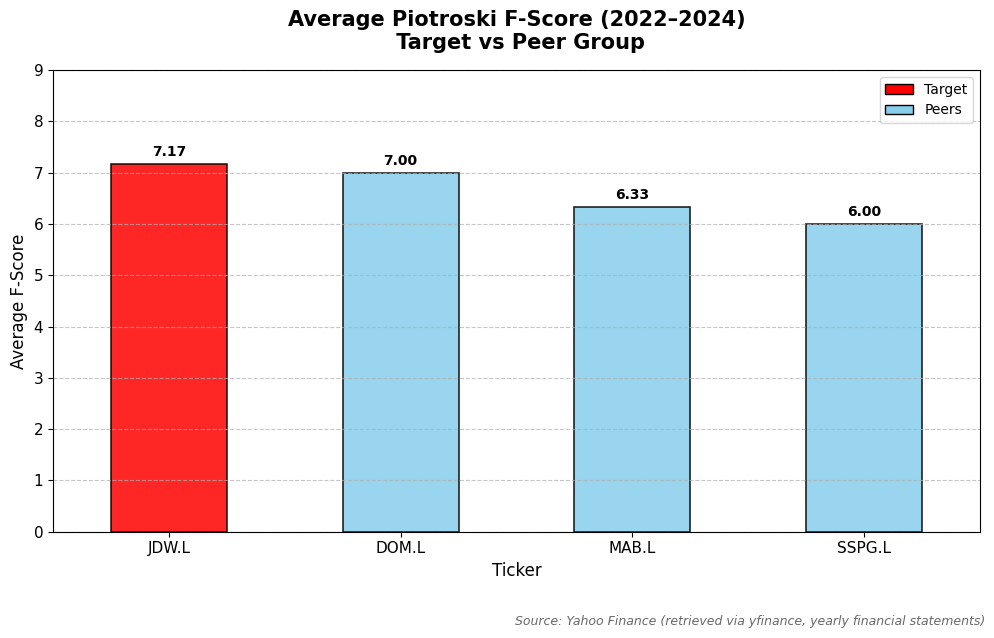

In [63]:
# ============================
# 1) Collect Target F-Scores
# ============================

target_scores = []  # Store yearly F-Scores for the target company

# Loop through all years except the last one (since no prior year for comparison)
for i, year in enumerate(years[:-1]):
    prior_year = years[i+1]  # Define the prior year for comparison
    try:
        # Compute Piotroski F-Score for the target company using financial statements
        year_df, total_f_score = compute_piotroski_f_score(
            target_ticker.ticker,   # ✅ Use ticker symbol string, not yfinance object
            year,
            prior_year,
            balance_sheet_target,
            income_statement_target,
            cash_flow_target
        )
        target_scores.append(total_f_score)  # Save score for this year
    except Exception as e:
        # Gracefully handle any computation error
        print(f"Error computing {target_ticker.ticker} for {year}: {e}")

# Calculate the average F-Score across all available years for the target company
target_avg = np.mean(target_scores) if target_scores else np.nan


# ============================
# 2) Collect peer averages
# ============================

peer_avgs = {}  # Dictionary to hold peers' average F-Scores

# Loop through all peer tickers and their stored results
for peer_ticker_symbol, yearly_data in results_dict.items():
    f_scores = []  # List to collect yearly F-Scores for each peer
    for year, result in yearly_data.items():
        # Only add valid scores (ignore missing/None)
        if result.get("Total F-Score") is not None:
            f_scores.append(result["Total F-Score"])
    # If peer has valid scores, calculate their average
    if f_scores:
        peer_avgs[peer_ticker_symbol] = np.mean(f_scores)


# ============================
# 3) Combine target + peers
# ============================

# Build a comparison DataFrame for target and peers
comparison_df = pd.DataFrame({
    "Ticker": [target_ticker.ticker] + list(peer_avgs.keys()),  # Add target ticker + peers
    "Average F-Score": [target_avg] + list(peer_avgs.values())  # Add their averages
}).set_index("Ticker")  # Use ticker as index for plotting

# Sort by average F-Score descending for cleaner visualization
comparison_df = comparison_df.sort_values("Average F-Score", ascending=False)


# ============================
# 4) Bar Plot (highlight target_ticker, add legend, clean title)
# ============================

plt.figure(figsize=(10, 6))  # Set figure size for readability

# Highlight target ticker in red, peers in blue
colors = ["red" if t == target_ticker.ticker else "skyblue" for t in comparison_df.index]

# Create bar plot of average F-Scores
ax = comparison_df["Average F-Score"].plot(
    kind="bar",           # Bar chart
    color=colors,         # Apply colors (red for target, blue for peers)
    edgecolor="black",    # Black border for bars
    linewidth=1.2,        # Slightly thicker borders
    alpha=0.85            # Slight transparency for softer look
)

# ============================
# Title (clean + professional)
# ============================

plt.title(
    f"Average Piotroski F-Score (2022–2024)\n Target vs Peer Group",
    fontsize=15, weight="bold", pad=15
)

# Axis labels
plt.ylabel("Average F-Score", fontsize=12)
plt.xlabel("Ticker", fontsize=12)

# Fix y-axis range (0–9, since Piotroski F-Score is within this scale)
plt.ylim(0, 9)

# Format tick labels for readability
plt.xticks(rotation=0, fontsize=11)  # Keep x-axis labels horizontal
plt.yticks(fontsize=11)

# Add horizontal dashed gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add numeric labels above each bar
for i, v in enumerate(comparison_df["Average F-Score"]):
    ax.text(i, v + 0.15, f"{v:.2f}", ha="center", fontsize=10, weight="bold")

# ============================
# Legend
# ============================

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="red", edgecolor="black", label=f"Target"),
    Patch(facecolor="skyblue", edgecolor="black", label="Peers")
]
plt.legend(handles=legend_elements, loc="upper right", fontsize=10, frameon=True)


# ============================
# Caption (bottom-right, styled)
# ============================

plt.figtext(
    0.99, -0.05,  # Place text bottom-right
    "Source: Yahoo Finance (retrieved via yfinance, yearly financial statements)",
    ha="right", fontsize=9, style="italic", color="dimgray"
)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

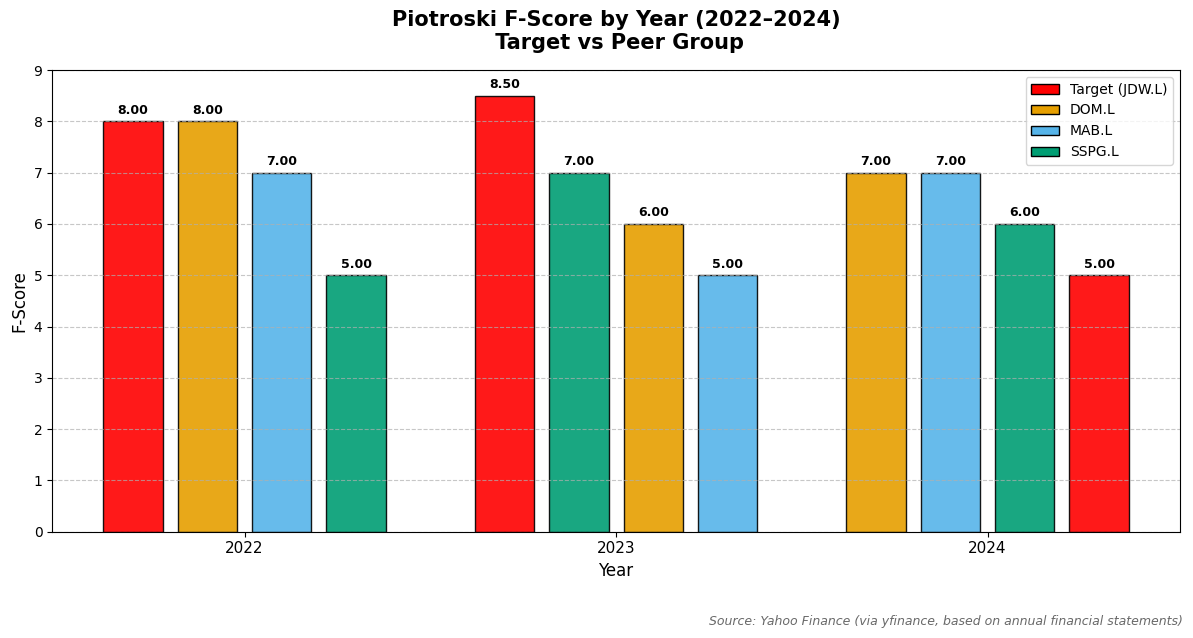

In [64]:
# ============================
# 5) Yearly Piotroski F-Score Comparison (Enhanced)
# ============================

# --- Helper function to extract only the year ---
def extract_year(y):
    try:
        return int(str(y)[:4])  # take the first 4 characters
    except:
        return y

# Build a long-format DataFrame for yearly scores
yearly_data = []

# Add target yearly scores
for i, year in enumerate(years[:-1]):  # exclude last year (no prior year)
    yearly_data.append({
        "Ticker": target_ticker.ticker,
        "Year": extract_year(year),
        "F-Score": target_scores[i]
    })

# Add peers yearly scores
for peer_ticker_symbol, yearly_dict in results_dict.items():
    for year, result in yearly_dict.items():
        if result.get("Total F-Score") is not None:
            yearly_data.append({
                "Ticker": peer_ticker_symbol,
                "Year": extract_year(year),
                "F-Score": result["Total F-Score"]
            })

yearly_df = pd.DataFrame(yearly_data)
yearly_df = yearly_df.sort_values(["Year", "F-Score"], ascending=[True, False])

# ============================
# Bar Plot by Year
# ============================

plt.figure(figsize=(12, 6))
unique_years = sorted(yearly_df["Year"].unique())

# Color-blind friendly palette (Okabe-Ito palette)
palette = [
    "#E69F00", "#56B4E9", "#009E73",
    "#F0E442", "#0072B2", "#D55E00", "#CC79A7"
]

# Assign peer colors dynamically
peer_tickers = [t for t in yearly_df["Ticker"].unique() if t != target_ticker.ticker]
peer_colors = {ticker: palette[i % len(palette)] for i, ticker in enumerate(peer_tickers)}

cluster_centers, labels = [], []
x_pos = 0

for year in unique_years:
    subset = yearly_df[yearly_df["Year"] == year].sort_values("F-Score", ascending=False)
    x_positions = np.arange(len(subset)) + x_pos

    # Assign colors: target red, peers distinct colors
    colors = [
        "red" if t == target_ticker.ticker else peer_colors.get(t, "skyblue")
        for t in subset["Ticker"]
    ]

    plt.bar(x_positions, subset["F-Score"], color=colors, edgecolor="black", alpha=0.9)

    # Labels above bars
    for i, v in enumerate(subset["F-Score"]):
        plt.text(x_positions[i], v + 0.15, f"{v:.2f}", ha="center", fontsize=9, weight="bold")

    cluster_centers.append(x_positions.mean())
    labels.append(str(year))
    x_pos += len(subset) + 1

# ============================
# Axis + Labels
# ============================

plt.title("Piotroski F-Score by Year (2022–2024)\n Target vs Peer Group",
          fontsize=15, weight="bold", pad=15)
plt.ylabel("F-Score", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylim(0, 9)
plt.xticks(cluster_centers, labels, fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# ============================
# Legend
# ============================

legend_elements = [Patch(facecolor="red", edgecolor="black", label=f"Target ({target_ticker.ticker})")]
for t, c in peer_colors.items():
    legend_elements.append(Patch(facecolor=c, edgecolor="black", label=t))
plt.legend(handles=legend_elements, loc="upper right", fontsize=10, frameon=True)

# ============================
# Caption
# ============================

plt.figtext(
    0.99, -0.05,
    "Source: Yahoo Finance (via yfinance, based on annual financial statements)",
    ha="right", fontsize=9, style="italic", color="dimgray"
)

plt.tight_layout()
plt.show()